# ***Imports / Loading language model***

In [1]:
# import relevant libraries

import pandas as pd
import re
import numpy as np
import spacy
from transformers import pipeline
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARMA
from pandas import datetime
from scipy.stats import pearsonr
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

C:\Users\SEBAST~1.KEI\AppData\Local\Temp/ipykernel_5088/2770149886.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# load language model: spacy english corpus LARGE

nlp = spacy.load('en_core_web_lg')

# ***Checkpoint 01: Raw, extracted news***

In [3]:
### CHECKPOINT 1: read in raw, extracted data ###

# read dataframe containing all the scraped text

fin_news = pd.read_csv('../files/checkpoints/c01_rawnews.csv', index_col=0)

In [4]:
fin_news.head()

,url,headline,raw_article,date,ticker
0,https://www.investing.com/news/stock-market-ne...,"Apple's new car software no threat, complement...",TOKYO (Reuters) - Panasonic (OTC:PCRFY) Holdin...,"3 hours ago (Jun 08, 2022 03:52AM ET)",AAPL
1,https://www.investing.com/news/stock-market-ne...,"Dow Futures Tick Lower, Smartsheet Reports",By Oliver Gray Investing.com - U.S. stock futu...,"11 hours ago (Jun 07, 2022 07:00PM ET)",AAPL
2,https://www.investing.com/news/stock-market-ne...,U.S. stocks higher at close of trade; Dow Jone...,Investing.com – U.S. stocks were higher after ...,"14 hours ago (Jun 07, 2022 04:25PM ET)",AAPL
3,https://www.investing.com/news/stock-market-ne...,Shopify shareholders give CEO 40% voting stake...,(Reuters) - Shareholders of Shopify (NYSE:SHOP...,"15 hours ago (Jun 07, 2022 03:10PM ET)",AAPL
4,https://www.investing.com/news/stock-market-ne...,Analysis - Apple's next frontier is your car's...,By Stephen Nellis and Joseph White(Reuters) - ...,"17 hours ago (Jun 07, 2022 01:53PM ET)",AAPL


In [5]:
print("Total amount of articles: ", len(fin_news))

Total amount of articles:  29787


In [6]:
# inspect missing values

fin_news.isna().sum()

url               0
headline          0
raw_article    3589
date             43
ticker            0
dtype: int64

## C01.1 Data cleaning

### C01.1.1: Clean dates ###

In [7]:
# convert date column to str so we may apply string formatting methods

fin_news['date'] = fin_news['date'].apply(str)

In [8]:
# function to extract and convert the datetime column

def clean_dates(date_str):
  #date_str = str(date_str)
  # filter out the brackets
  if "hours ago" or "minutes ago" in date_str:
    #date_str = str(re.findall(r'\(.*?\)', date_str))[3:-3]
    left_idx = date_str.find('(')
    right_idx = date_str.find(')', left_idx)
    
    date_str = date_str[left_idx+1:right_idx]
    date_str = date_str.replace("ET", "")
    date_str = date_str.replace("E", "")
    
  return date_str

In [9]:
# apply cleaning function to date

fin_news['date'] = fin_news['date'].apply(clean_dates)

In [10]:
# classify NaNs

def find_nans(date_str):
    if 'na' in date_str:
        date_str = np.NaN
    return date_str

In [11]:
fin_news['date'] = fin_news['date'].apply(find_nans)

In [12]:
fin_news.head()

,url,headline,raw_article,date,ticker
0,https://www.investing.com/news/stock-market-ne...,"Apple's new car software no threat, complement...",TOKYO (Reuters) - Panasonic (OTC:PCRFY) Holdin...,"Jun 08, 2022 03:52AM",AAPL
1,https://www.investing.com/news/stock-market-ne...,"Dow Futures Tick Lower, Smartsheet Reports",By Oliver Gray Investing.com - U.S. stock futu...,"Jun 07, 2022 07:00PM",AAPL
2,https://www.investing.com/news/stock-market-ne...,U.S. stocks higher at close of trade; Dow Jone...,Investing.com – U.S. stocks were higher after ...,"Jun 07, 2022 04:25PM",AAPL
3,https://www.investing.com/news/stock-market-ne...,Shopify shareholders give CEO 40% voting stake...,(Reuters) - Shareholders of Shopify (NYSE:SHOP...,"Jun 07, 2022 03:10PM",AAPL
4,https://www.investing.com/news/stock-market-ne...,Analysis - Apple's next frontier is your car's...,By Stephen Nellis and Joseph White(Reuters) - ...,"Jun 07, 2022 01:53PM",AAPL


In [13]:
# drop where date is NaN

fin_news = fin_news[fin_news['date'].notna()]

In [14]:
fin_news['date'] = pd.to_datetime(fin_news['date'])

### C01.1.2: Clean text 

In [15]:
# convert raw article to string object

fin_news['raw_article'] = fin_news['raw_article'].apply(str)

In [16]:
# clean some things up

def clean_up(raw_article):
    if type(raw_article) == "str":
        raw_article = raw_article.replace("–", "-")   # replace the longer slash in investing.com articles
    return raw_article

In [17]:
fin_news['raw_article'] = fin_news['raw_article'].apply(clean_up)

In [18]:
# function to extract the name of the source from the head of the text

def extract_source(raw_article):
    raw_article = str(raw_article)
    first_sent = raw_article.split('-')[0]
    author = "Unknown"
    if "Reuters" in first_sent:
        author = "Reuters"
    elif "Investing.com" in first_sent:
        author = "Investing.com"
    elif "IBT" in first_sent:
        author = "IBT"
    return author

In [19]:
fin_news['source'] = fin_news['raw_article'].apply(extract_source)

In [20]:
fin_news['source'].value_counts()

Reuters          14097
Investing.com     9138
Unknown           6509
Name: source, dtype: int64

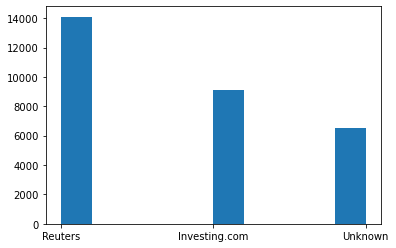

In [21]:
plt.hist(fin_news['source'])
plt.show()

In [22]:
def extract_article(raw_article):
    return "".join(raw_article.split('-')[1:])

In [23]:
# extract article (without header lines)

fin_news['article'] = fin_news['raw_article'].apply(extract_article)

In [24]:
fin_news.head()

,url,headline,raw_article,date,ticker,source,article
0,https://www.investing.com/news/stock-market-ne...,"Apple's new car software no threat, complement...",TOKYO (Reuters) - Panasonic (OTC:PCRFY) Holdin...,2022-06-08 03:52:00,AAPL,Reuters,Panasonic (OTC:PCRFY) Holdings Corp does not ...
1,https://www.investing.com/news/stock-market-ne...,"Dow Futures Tick Lower, Smartsheet Reports",By Oliver Gray Investing.com - U.S. stock futu...,2022-06-07 19:00:00,AAPL,Investing.com,U.S. stock futures traded lower during Tuesda...
2,https://www.investing.com/news/stock-market-ne...,U.S. stocks higher at close of trade; Dow Jone...,Investing.com – U.S. stocks were higher after ...,2022-06-07 16:25:00,AAPL,Investing.com,year highs; rising 5.85% or 2.84 to 51.39. Sha...
3,https://www.investing.com/news/stock-market-ne...,Shopify shareholders give CEO 40% voting stake...,(Reuters) - Shareholders of Shopify (NYSE:SHOP...,2022-06-07 15:10:00,AAPL,Reuters,Shareholders of Shopify (NYSE:SHOP) Inc on Tu...
4,https://www.investing.com/news/stock-market-ne...,Analysis - Apple's next frontier is your car's...,By Stephen Nellis and Joseph White(Reuters) - ...,2022-06-07 13:53:00,AAPL,Reuters,Apple Inc (NASDAQ:AAPL) wants to power the da...


In [25]:
# map tickers to company names

def get_company_name(ticker, company_names:dict):
    return company_names[ticker]

In [26]:
company_names = {"AAPL": "Apple",
                "AMGN": "Amgen",
                "AXP": "American Express",
                "BA": "Boeing",
                "CAT": "Caterpillar",
                "CSCO": "Cisco",
                "CVX": "Chevron",
                "GS": "Goldman Sachs",
                "HD": "Home Depot",
                "HON": "Honeywell",
                "IBM": "IBM",
                "INTC": "Intel",
                "KO": "Coca Cola",
                "JPM": "JP Morgan",
                "MCD": "Mc Donalds",
                "MMM": "3M",
                "MRK": "Merck",
                "MSFT": "Microsoft",
                "NKE": "Nike",
                "PG": "Procter Gamble",
                "TRV": "Travelers",
                "UNH": "United Health Group",
                "CRM": "Salesforce",
                "VZ": "Verizon",
                "V": "Visa",
                "WBA": "Walgreen",
                "WMT": "Walmart",
                "DIS": "Disney",
                }

fin_news['company_name'] = fin_news['ticker'].apply(get_company_name, args=[company_names])

In [27]:
# function to detect if ticker company is main subject of the article (see if name or ticker shows up in headline)

fin_news['is_main_subject'] = fin_news.apply(lambda x: (x.company_name or x.ticker) in x.headline, axis=1)

In [28]:
# proportion of articles where firm is main subject

proportions = {}
for company_name in np.unique(fin_news.ticker.values):
    prop = len(fin_news[(fin_news['is_main_subject'] == True) & (fin_news['ticker'] == company_name)])/ len(fin_news[fin_news['ticker']==company_name])
    proportions[company_name] = prop
    #print(f"{company_name} proportion: ", len(fin_news[(fin_news['is_main_subject'] == True) & (fin_news['ticker'] == company_name)])/ len(fin_news[fin_news['ticker']==company_name]))

In [29]:
# convert articles to spacy nlp objects (for sentence parsing)

fin_news['doc'] = fin_news['article'].apply(nlp)

In [30]:
# function to parse sentences

def splitup_sentences(doc):
    return list(doc.sents)

In [31]:
fin_news['sentences'] = fin_news['doc'].apply(splitup_sentences)

In [32]:
fin_news.head()

,url,headline,raw_article,date,ticker,source,article,company_name,is_main_subject,doc,sentences
0,https://www.investing.com/news/stock-market-ne...,"Apple's new car software no threat, complement...",TOKYO (Reuters) - Panasonic (OTC:PCRFY) Holdin...,2022-06-08 03:52:00,AAPL,Reuters,Panasonic (OTC:PCRFY) Holdings Corp does not ...,Apple,True,"( , Panasonic, (, OTC, :, PCRFY, ), Holdings, ...","[( , Panasonic, (, OTC, :, PCRFY, )), (Holding..."
1,https://www.investing.com/news/stock-market-ne...,"Dow Futures Tick Lower, Smartsheet Reports",By Oliver Gray Investing.com - U.S. stock futu...,2022-06-07 19:00:00,AAPL,Investing.com,U.S. stock futures traded lower during Tuesda...,Apple,False,"( , U.S., stock, futures, traded, lower, durin...","[( , U.S., stock, futures, traded, lower, duri..."
2,https://www.investing.com/news/stock-market-ne...,U.S. stocks higher at close of trade; Dow Jone...,Investing.com – U.S. stocks were higher after ...,2022-06-07 16:25:00,AAPL,Investing.com,year highs; rising 5.85% or 2.84 to 51.39. Sha...,Apple,False,"(year, highs, ;, rising, 5.85, %, or, 2.84, to...","[(year, highs, ;, rising, 5.85, %, or, 2.84, t..."
3,https://www.investing.com/news/stock-market-ne...,Shopify shareholders give CEO 40% voting stake...,(Reuters) - Shareholders of Shopify (NYSE:SHOP...,2022-06-07 15:10:00,AAPL,Reuters,Shareholders of Shopify (NYSE:SHOP) Inc on Tu...,Apple,False,"( , Shareholders, of, Shopify, (, NYSE, :, SHO...","[( , Shareholders, of, Shopify, (, NYSE, :, SH..."
4,https://www.investing.com/news/stock-market-ne...,Analysis - Apple's next frontier is your car's...,By Stephen Nellis and Joseph White(Reuters) - ...,2022-06-07 13:53:00,AAPL,Reuters,Apple Inc (NASDAQ:AAPL) wants to power the da...,Apple,True,"( , Apple, Inc, (, NASDAQ, :, AAPL, ), wants, ...","[( , Apple, Inc, (, NASDAQ, :, AAPL, ), wants,..."


In [33]:
# function to convert seperated sentences back to strings (from spacy objects)

def sentences_str(sentences):
  str_sentences = [sentence.text for sentence in sentences]
  return str_sentences

In [34]:
fin_news['sentences_str'] = fin_news['sentences'].apply(sentences_str)

In [35]:
# function to extract sentences that mention the company

fin_news['subject_sentences'] = fin_news.apply(lambda x: [sentence for sentence in x.sentences_str if (x.company_name in sentence or x.ticker in sentence)], axis=1)

In [36]:
# filter out text signal based on headline heuristic (company name should show up in headline)
# toDO: make this more elaborate by including all company name variations

fin_news['text_signal'] = fin_news.apply(lambda x: x.sentences_str if x.is_main_subject else x.subject_sentences, axis=1)

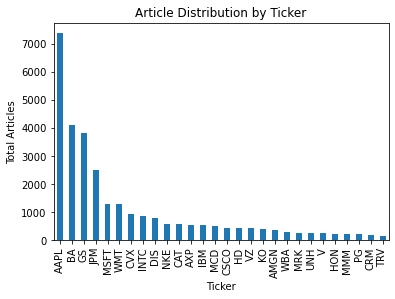

In [41]:
# make article distribution plot

fin_news['ticker'].value_counts().plot.bar()
plt.xlabel('Ticker')
plt.ylabel('Total Articles')
plt.title('Article Distribution by Ticker')
plt.savefig('../files/experiment_outputs/article_dist2.png')
plt.show()

In [42]:
# save as csv file

fin_news.to_csv('../files/checkpoints/c02_preprocessednews.csv')

# ***Checkpoint 02: Pre-processed news***

- In this section, I will perform further EDA and move to signal extraction

In [40]:
### CHECKPOINT 2: Analyzing the pre-processed textual data ###

# load in the csv

fin_news = pd.read_csv('../files/checkpoints/c02_preprocessednews.csv')

In [43]:
# replace IBT with 'other' for easier visualization

def replace_ibt(source_name):
    if source_name == 'IBT':
        source_name = 'Unknown'
    return source_name

fin_news['source'] = fin_news['source'].apply(replace_ibt)

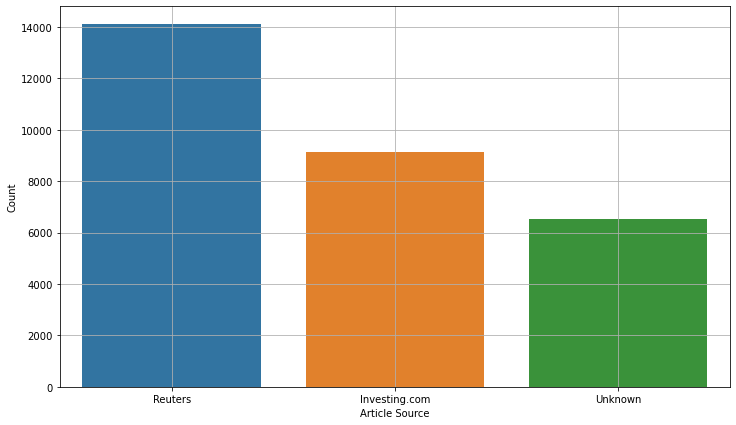

In [44]:
# plot the article sources

fig, ax = plt.subplots(figsize=(12, 7))
sns.countplot(x='source', data=fin_news)
plt.xlabel('Article Source')
plt.ylabel('Count')
ax.grid()
plt.savefig('../files/experiment_outputs/article_source_dist.png')
plt.show()

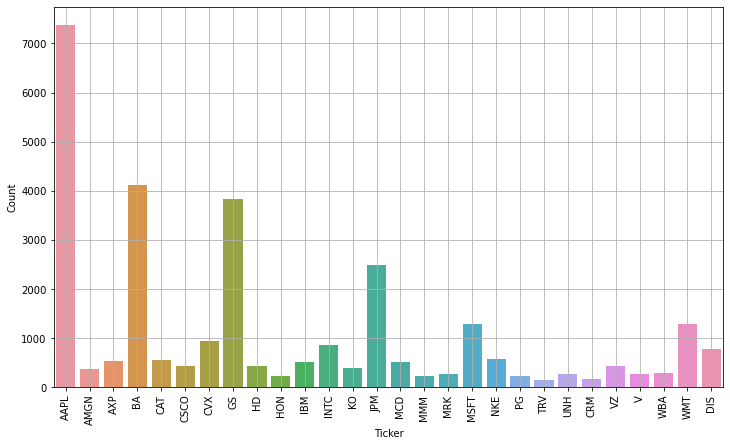

In [45]:
# make article distribution plot

fig, ax = plt.subplots(figsize=(12, 7))
sns.countplot(x='ticker', data=fin_news)
plt.xlabel('Ticker')
plt.ylabel('Count')
ax.grid()
plt.xticks(rotation=90)
plt.savefig('../files/experiment_outputs/ticker_dist.png')
plt.show()

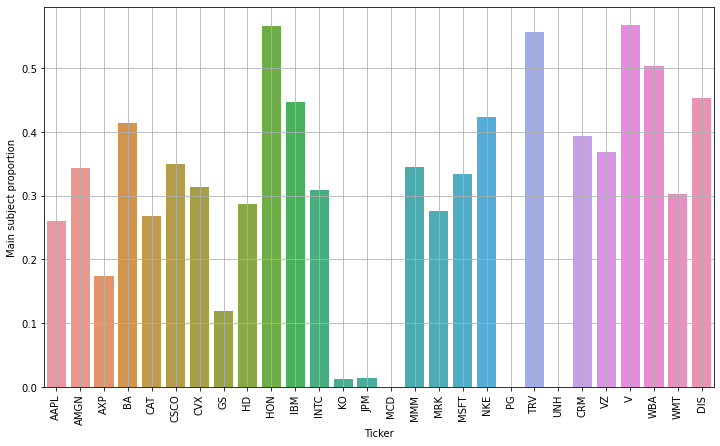

In [46]:
# extract main-subject-proportions and plot them

main_subj_prop = {}

tickers = list(fin_news['ticker'].unique())

for ticker in tickers:
    prop = len(fin_news[(fin_news['ticker'] == ticker) & (fin_news['is_main_subject'])]) / len(fin_news[fin_news['ticker'] == ticker])
    main_subj_prop[ticker] = prop
    
    
# make plot
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x=list(main_subj_prop.keys()), y=list(main_subj_prop.values()))
plt.xticks(rotation=90)
plt.xlabel('Ticker')
plt.ylabel('Main subject proportion')
ax.grid()
plt.savefig('../files/experiment_outputs/main_subj_prop.png')
plt.show()

## C02.1 Fama-French Carhatt Model

In [59]:
ffc_df = pd.read_csv('../files/external/ffc_daily_dji.csv')

In [60]:
ffc_df.head()

,PERMNO,DATE,n,RET,alpha,b_mkt,b_smb,b_hml,b_umd,ivol,tvol,R2,exret,TICKER
0,10107,16/04/2020,252,3.0021%,0.0008,1.2323,-0.2850,-0.5204,0.1036,0.7887%,2.4801%,89.8877%,0.2489%,MSFT
1,10107,09/09/2020,252,4.2584%,0.0004,1.2405,-0.2005,-0.4982,0.0532,0.9182%,2.6547%,88.0377%,0.5090%,MSFT
2,10107,06/07/2018,252,1.4034%,0.0005,1.2574,-0.3325,-0.4966,0.4855,0.7125%,1.3802%,73.3528%,0.1124%,MSFT
3,10107,01/10/2018,252,1.0842%,0.0005,1.2306,-0.4456,-0.5268,0.5486,0.7155%,1.4203%,74.6229%,0.4305%,MSFT
4,10107,27/07/2021,252,-0.8684%,0.0003,1.1933,-0.4425,-0.3740,0.0438,0.8270%,1.6114%,73.6624%,-0.1039%,MSFT


In [61]:
# inspect datatypes

ffc_df.dtypes

PERMNO      int64
DATE       object
n           int64
RET        object
alpha     float64
b_mkt     float64
b_smb     float64
b_hml     float64
b_umd     float64
ivol       object
tvol       object
R2         object
exret      object
TICKER     object
dtype: object

In [62]:
# function to extract the percentage as a numerical (not string)

def extract_perc_str(perc_str):
    num = float(perc_str[:-1])
    return num/100
    
ffc_df['exret'] = ffc_df['exret'].apply(extract_perc_str)
ffc_df['RET'] = ffc_df['RET'].apply(extract_perc_str)

In [64]:
# function to plot the excess returns of FF against our sentiment signal

def make_ts_plot(sent_df, ffc_df, figname):
    """
    df1: dataframe containing sentiment signal
    df2: dataframe containing fama-french excess returns
    """
    fig, ax = plt.subplots()
    ax.plot(sent_df.index, sent_df.sent_val, label='sent')
    ax.grid()
    ax.set_xlabel('Date')
    ax.set_ylabel('Sentiment')
    ax.set_title(f'Sentiment Signal AAPL')
    ax.legend(loc=0)

    ax.set_xticklabels(sent_df.index, rotation=45)

    ax2 = ax.twinx()
    ax2.plot(ffc_df.index,ffc_df['exret'].values, color='red', label='ffc_exret')
    ax2.set_ylabel('Excess Returns')
    ax2.legend(loc=2)
    
    plt.savefig(figname)
    plt.show()

## C02.1 Sentiment signal extraction

In [65]:
# function to convert textual signal of a ticker into continious time-series signal

def extract_sentiment(ticker, df, sentiment_pipeline, sent_dict):
    """
    ticker: ticker name
    df: dataframe to contain all articles for all stocks
    sentiment_pipeline: huggingface pipeline object
    sent_dict: dictionary to store our results > ticker: signal
    """
    
    print('---' * 20)
    print(f'Extracting ticker: {ticker}')
    
    # extract ticker from dataframe
    ticker_df = df[df.ticker == ticker]
    
    # convert signal back to string
    ticker_df['text_signal'] = ticker_df['text_signal'].apply(str)
    
    # find max_lengths of the signal
    ticker_df['signal_len'] = ticker_df['text_signal'].apply(len)
    
    # for now: filter only options which have len < 512
    ticker_df = ticker_df[ticker_df['signal_len'] <= 512]
    
    # function to extract sentiment signal
    def extract_sent_signal(text_signal, sentiment_pipeline):
        output = sentiment_pipeline(text_signal)
        if output[0]['label'] == "positive":
            base_val = 1
        elif output[0]['label'] == "neutral":
            base_val = 0
        elif output[0]['label'] == "negative":
            base_val = -1
        val = output[0]['score'] * base_val
        return val
    
    # extract sentiment signal
    ticker_df['sent_val'] = ticker_df['text_signal'].apply(extract_sent_signal, args=[sentiment_pipeline])
    
    # store results
    sent_dict[ticker] = ticker_df
    

In [66]:
# initialize the sentiment pipeline with FinBERT model from Huggingface
sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# initialize empty sentence dictionary (for results)
sent_dict = {}

# extract list of tickers
tickers = list(company_names.keys())

for ticker in tickers:
    extract_sentiment(ticker, fin_news, sentiment_pipeline, sent_dict)

------------------------------------------------------------
Extracting ticker: AAPL


C:\Users\SEBAST~1.KEI\AppData\Local\Temp/ipykernel_22992/2251024480.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df['text_signal'] = ticker_df['text_signal'].apply(str)
C:\Users\SEBAST~1.KEI\AppData\Local\Temp/ipykernel_22992/2251024480.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df['signal_len'] = ticker_df['text_signal'].apply(len)


------------------------------------------------------------
Extracting ticker: AMGN
------------------------------------------------------------
Extracting ticker: AXP
------------------------------------------------------------
Extracting ticker: BA
------------------------------------------------------------
Extracting ticker: CAT
------------------------------------------------------------
Extracting ticker: CSCO
------------------------------------------------------------
Extracting ticker: CVX
------------------------------------------------------------
Extracting ticker: GS
------------------------------------------------------------
Extracting ticker: HD
------------------------------------------------------------
Extracting ticker: HON
------------------------------------------------------------
Extracting ticker: IBM
------------------------------------------------------------
Extracting ticker: INTC
------------------------------------------------------------
Extracting tick

In [67]:
# store as one big dataframe and save file

sent_signal_df = pd.concat(sent_dict)
sent_signal_df.to_csv('../files/checkpoints/c03_extractedsentiment.csv')

# ***Checkpoint 03: Extracted sentiment***

- run from here to skip all previous pre-processing steps
- starting with the already extracted sentiment signals

In [2]:
### CHECKPOINT 1 ###

# load in fama-french daily dataset
ffc_df = pd.read_csv('../files/external/ffc_daily_dji.csv')

# load in extracted sentiment signals
sent_signal_df = pd.read_csv('../files/checkpoints/c03_extractedsentiment.csv')

In [3]:
# function to extract the percentage as a numerical (not string)
# apply this on the excess returns dataframe

def extract_perc_str(perc_str):
    num = float(perc_str[:-1])
    return num/100
    
ffc_df['exret'] = ffc_df['exret'].apply(extract_perc_str)
ffc_df['RET'] = ffc_df['RET'].apply(extract_perc_str)

### ***Fama-French EDA***

In [4]:
# make a table for summary statistics of Fama-French-Carhatt data


ffc_sumstats = ffc_df.describe()


# apply some transformations to make table for readable
ffc_sumstats = ffc_sumstats.drop(['PERMNO', 'n'], axis=1)
ffc_sumstats = ffc_sumstats.drop('count', axis=0)

ffc_sumstats['RET'] = ffc_sumstats['RET'] * 100
ffc_sumstats['exret'] = ffc_sumstats['exret'] * 100


formats = {'RET': '{:.2f}', 
           'alpha': '{:.5f}',
           'b_mkt': '{:.2f}',
           'b_smb': '{:.2f}',
           'b_hml': '{:.2f}',
           'b_umd': '{:.2f}',
           'exret': '{:.5f}', 
          }

for col, f in formats.items():
    ffc_sumstats[col] = ffc_sumstats[col].map(lambda x: f.format(x))


#ffc_sumstats['alpha'] = ffc_sumstats['alpha'].round(3)


print(ffc_sumstats.to_latex())

\begin{tabular}{llllllll}
\toprule
{} &     RET &     alpha & b\_mkt &  b\_smb &  b\_hml &  b\_umd &      exret \\
\midrule
mean &    0.07 &   0.00006 &  0.97 &  -0.18 &   0.12 &  -0.04 &   -0.00024 \\
std  &    1.82 &   0.00066 &  0.26 &   0.23 &   0.50 &   0.31 &    1.23230 \\
min  &  -23.85 &  -0.00330 &  0.29 &  -1.11 &  -1.31 &  -1.28 &  -15.35100 \\
25\%  &   -0.65 &  -0.00030 &  0.79 &  -0.32 &  -0.22 &  -0.21 &   -0.55755 \\
50\%  &    0.08 &   0.00010 &  0.98 &  -0.20 &   0.04 &  -0.02 &   -0.00590 \\
75\%  &    0.83 &   0.00050 &  1.15 &  -0.06 &   0.40 &   0.16 &    0.54255 \\
max  &   26.04 &   0.00250 &  1.76 &   0.81 &   1.60 &   1.28 &   24.20990 \\
\bottomrule
\end{tabular}



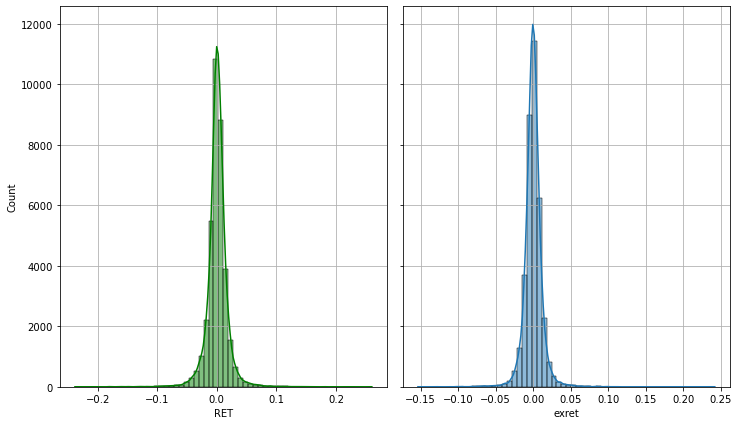

In [5]:
### make histograms for returns and excess returns

fig = plt.figure(figsize=(12,7))
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.05)
axs = gs.subplots(sharey=True)
sns.histplot(x='RET', data=ffc_df, kde=True, bins=60, ax=axs[0], color='green', label='Return')
axs[0].grid()
sns.histplot(x='exret', data=ffc_df, kde=True, bins=60, ax=axs[1])
axs[1].grid()
plt.savefig('../files/experiment_outputs/ret_dist.png')

In [6]:
### run shapiro test for normality on returns and excess returns

# H0: data was drawn from a normal distribution
# H1: data was not drawn from a normal distribution

from scipy.stats import shapiro

ret_test = shapiro(ffc_df['RET'].values)
print('returns: ', ret_test)

xret_test = shapiro(ffc_df['exret'].values)
print('excess returns: ', xret_test)

returns:  ShapiroResult(statistic=0.84464430809021, pvalue=0.0)
excess returns:  ShapiroResult(statistic=0.8603953123092651, pvalue=0.0)


C:\Users\sebastian.keil\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [7]:
# store dictionary with firm tickers and names

company_names = {"AAPL": "Apple",
                "AMGN": "Amgen",
                "AXP": "American Express",
                "BA": "Boeing",
                "CAT": "Caterpillar",
                "CSCO": "Cisco",
                "CVX": "Chevron",
                "GS": "Goldman Sachs",
                "HD": "Home Depot",
                "HON": "Honeywell",
                "IBM": "IBM",
                "INTC": "Intel",
                "KO": "Coca Cola",
                "JPM": "JP Morgan",
                "MCD": "Mc Donalds",
                "MMM": "3M",
                "MRK": "Merck",
                "MSFT": "Microsoft",
                "NKE": "Nike",
                "PG": "Procter Gamble",
                "TRV": "Travelers",
                "UNH": "United Health Group",
                "CRM": "Salesforce",
                "VZ": "Verizon",
                "V": "Visa",
                "WBA": "Walgreen",
                "WMT": "Walmart",
                "DIS": "Disney",
                }

In [8]:
# for sentiment: create dictionary of dataframes

"""
sent_dict: dictionary mapping ticker -> sentiment signal dataframa
"""

sent_dict = {}

for ticker in list(company_names.keys()):
    sent_dict[ticker] = sent_signal_df[sent_signal_df['ticker'] == ticker]
    # some more cleaning
    sent_dict[ticker] = sent_dict[ticker].drop(['Unnamed: 0', 'Unnamed: 1'], axis=1)

In [9]:
# function for basic pre-processing steps like converting to datetime, setting datetime index and aggregating to daily

def preprocess(df):
    
    # convert datacolumn to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # set the datetime index
    df = df.set_index('date')
    
    # apply smoothing operation
    df = df.resample('1D').mean()
    
    # filter out dates
    df = df[(df.index.year > 2016) & (df.index.year < 2022)]
    
    return df    

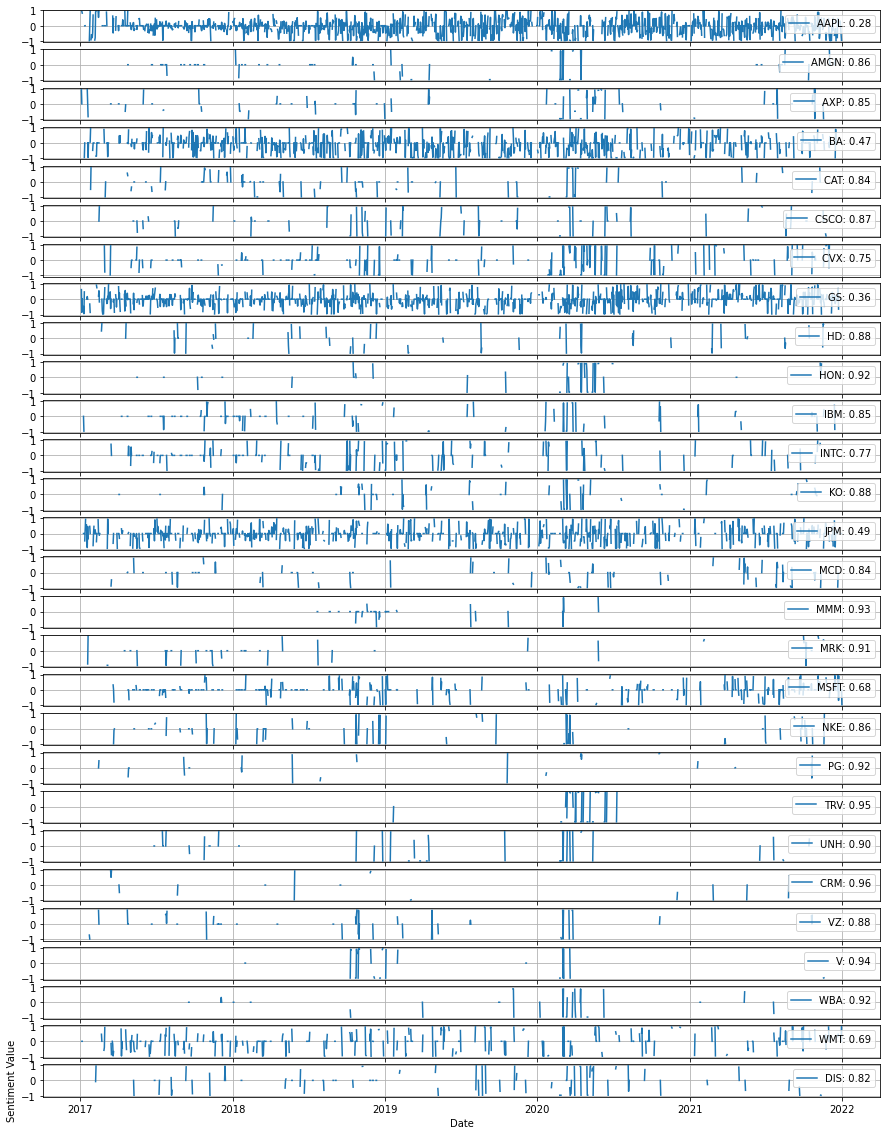

In [10]:
### compute sparsity ratio / plots for all 30 stocks (including sparsity label) ###

sent_dict_c = {}       # cleaned sentiment dictionary
sparsity_ratios = {}

"""
sent_dict_c: cleaned dictionary with articles and sentiment, ordered along time-series
sparsity_ratios: mapping ticker -> sparsity
"""

# plot outline
fig = plt.figure()
fig.set_size_inches(15, 20)
gs = fig.add_gridspec(nrows=len(sent_dict), ncols=1)
axs = gs.subplots(sharex=True)

for i, ticker in enumerate(sent_dict.keys()):
    # make pre-processing steps
    sent_dict_c[ticker] = preprocess(sent_dict[ticker])
    
    # compute and store sparsity
    sparsity = sent_dict_c[ticker]['sent_val'].isna().sum()/len(sent_dict_c[ticker]['sent_val'])
    sparsity_ratios[ticker] = sparsity
    
    # add another layer to our plot
    axs[i].plot(sent_dict_c[ticker]['sent_val'], label=f"{ticker}: {sparsity:.2f}")
    axs[i].grid()
    axs[i].legend(loc=1)

plt.ylabel('Sentiment Value')
plt.xlabel('Date')
plt.savefig('../files/experiment_outputs/dji30_sentval.png')
plt.show()

In [11]:
# function to find longest stretch without NaNs

'''
NOTE: to be used in the case study later on
'''

def find_longest_nonnull(x):
    # pad with np.nan
    x = np.append(np.nan, np.append(x, np.nan))
    # find where null
    w = np.where(np.isnan(x))[0]
    # diff to find length of stretch
    # argmax to find where largest stretch
    a = np.diff(w).argmax()
    # return original positions of boundary nulls
    return w[[a, a + 1]] + np.array([0, -2])


In [12]:
# print out longest non-null stretch for each company 

print('AAPL', find_longest_nonnull(sent_dict_c['AAPL'].sent_val))

AAPL [415 428]


### ***Sentiment Signal EDA***

In [13]:
# make summary stats of the sentiment signal

pd.set_option('display.float_format', lambda x: '%.3f' % x)

sent_df = pd.concat(sent_dict_c, axis=0)

sent_sum_stats = sent_df['sent_val'].groupby(level=0).describe()

sent_sum_stats['sparsity'] = list(sparsity_ratios.values())

sent_sum_stats['count'] =  sent_sum_stats['count'].astype(int)

#sent_sum_stats = sent_sum_stats.apply("{0:.4f}".format)

print(sent_sum_stats.to_latex())


\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  count &   mean &   std &    min &    25\% &   50\% &   75\% &   max &  sparsity \\
\midrule
AAPL &   1311 & -0.070 & 0.458 & -0.973 & -0.351 & 0.000 & 0.181 & 0.954 &     0.282 \\
AMGN &    249 & -0.038 & 0.524 & -0.974 &  0.000 & 0.000 & 0.000 & 0.944 &     0.864 \\
AXP  &    281 & -0.022 & 0.542 & -0.974 & -0.223 & 0.000 & 0.000 & 0.956 &     0.846 \\
BA   &    971 & -0.123 & 0.528 & -0.974 & -0.484 & 0.000 & 0.035 & 0.955 &     0.468 \\
CAT  &    295 & -0.026 & 0.564 & -0.974 & -0.353 & 0.000 & 0.004 & 0.951 &     0.838 \\
CRM  &     77 &  0.032 & 0.579 & -0.975 &  0.000 & 0.000 & 0.506 & 0.956 &     0.870 \\
CSCO &    238 & -0.023 & 0.621 & -0.974 & -0.483 & 0.000 & 0.422 & 0.954 &     0.751 \\
CVX  &    454 & -0.054 & 0.589 & -0.974 & -0.484 & 0.000 & 0.000 & 0.954 &     0.361 \\
DIS  &    324 & -0.046 & 0.612 & -0.974 & -0.498 & 0.000 & 0.113 & 0.955 &     0.879 \\
GS   &   1167 & -0.036 & 0.421 & -0.973 & -0.243 & 0.000 & 0.077 & 0.956 

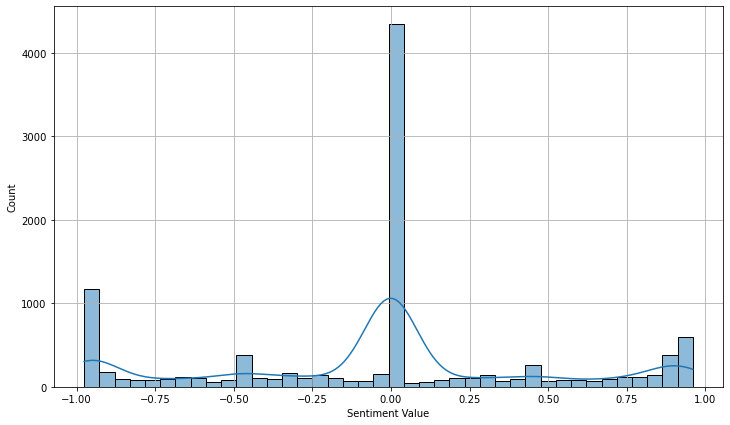

In [14]:
# make a histogram of the sentiment values for all stocks without imputation

fig, ax = plt.subplots(figsize=(12,7))
sns.histplot(x='sent_val', bins=40, data=sent_df, kde=True)
ax.grid()
plt.xlabel('Sentiment Value')
plt.savefig('../files/experiment_outputs/sent_hist.png')

# Feature Engineering/Pre-processing for Model building

1) We test out the decay-factor imputation described in the thesis

- we want to build a machine-learning model that receives all features up until point t-1
- based on the previous autoregressive analysis, let's consider information up until 10 point back in time (t-10)
- we predict the excess returns at point t
- based on this model, we will build an automated trading strategy
- we will test this using the four models that have sufficient sparsity

### ***Imputation***

In [15]:
# let's filter out only AAPL, BA, GS, JPM

tickers = ['AAPL', 'BA', 'GS', 'JPM']
chosen4_sent = {ticker: sent_dict_c[ticker] for ticker in tickers}

In [16]:
# test number of NaNs to see if chosen4_sent is modified by other function later (it should not be)

chosen4_sent['AAPL']['sent_val'].isna().sum()

515

In [17]:
# function perform discount-factor imputation

def discount_imputation(df, discount_factor):
    new_df = df.copy(deep=True)
    sent_arr = new_df['sent_val'].values
    
    for i in range(1, len(sent_arr)):
        if pd.isna(sent_arr[i]) and not(pd.isna(sent_arr[i-1])):
            sent_arr[i] = discount_factor * sent_arr[i-1]
    
    new_df['sent_val'] = sent_arr
    return new_df

In [21]:

# plot our sentiment values for the four chosen companies before and after discount imputation

import copy

def make_imputation_plot(chosen4_sent, discount_factor):

    imputed = copy.deepcopy(chosen4_sent)          # make new copy of original dictionary
    
    fig = plt.figure(figsize=(12,7))

    gs = fig.add_gridspec(nrows=len(chosen4_sent), ncols=2, hspace=0.1, wspace=0.05)
    axs = gs.subplots(sharex=True, sharey=True)
    colors = ['darkmagenta', 'mediumorchid', 'blueviolet', 'darkorchid']
    
    for i, key in enumerate(chosen4_sent.keys()):
        
        # make imputations
        imputed[key] =  discount_imputation(imputed[key], discount_factor)
        axs[i,0].plot(chosen4_sent[key]['sent_val'][chosen4_sent[key].index.year == 2017], label=key, color=colors[i])
        axs[i,0].legend(loc=1)
        axs[i,0].grid()
        axs[i,1].plot(imputed[key]['sent_val'][imputed[key].index.year == 2017], label=key, color=colors[i])
        axs[i,1].legend(loc=1)
        axs[i,1].grid()
    #fig.text(0.5, 0, 'Date', ha='center')
    #fig.text(0, 0.5, 'Sentiment', va='center', rotation='vertical', wrap=True)
    axs[3,0].set_ylabel('Sentiment', rotation=90)
    axs[3,0].set_xlabel('Date', rotation=0)
    axs[3,1].set_xlabel('Date', rotation=0)
    axs[0,0].set_title('Not Including Time-discounting')
    axs[0,1].set_title(f'Including Time-discounting ($\gamma={discount_factor}$)')
    fig.autofmt_xdate(rotation=45)
    plt.savefig(f'../files/experiment_outputs/gamma_{discount_factor}_comp.png')

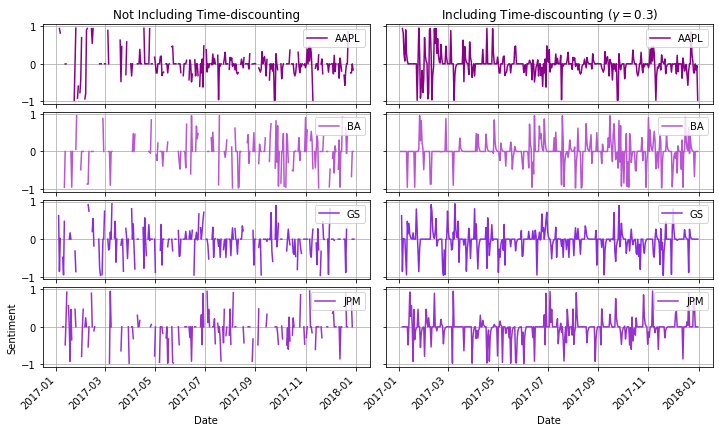

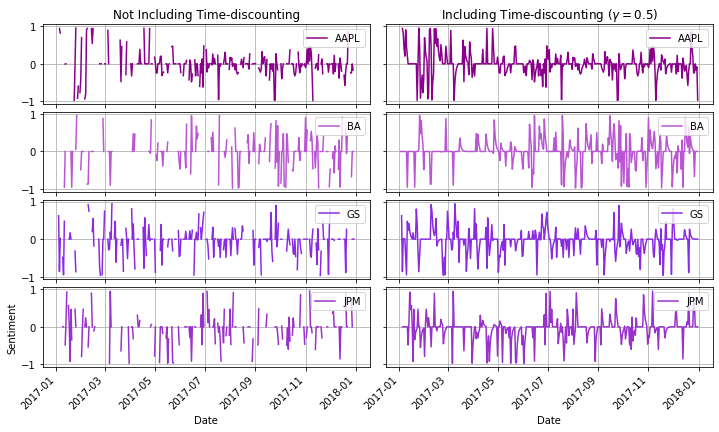

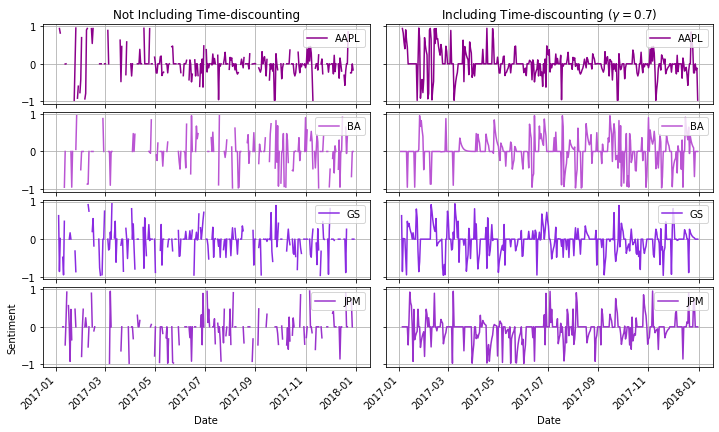

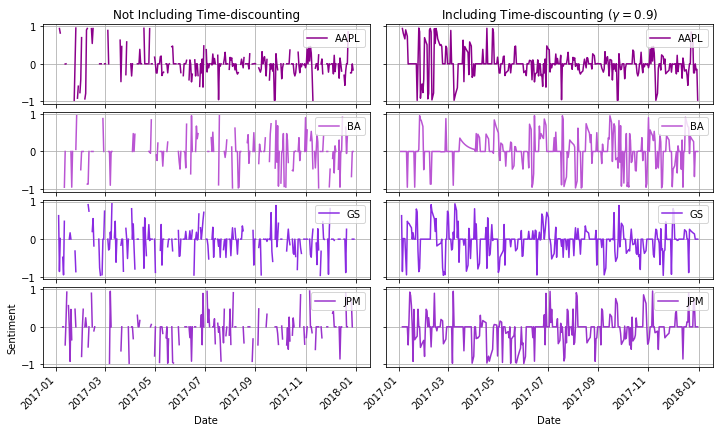

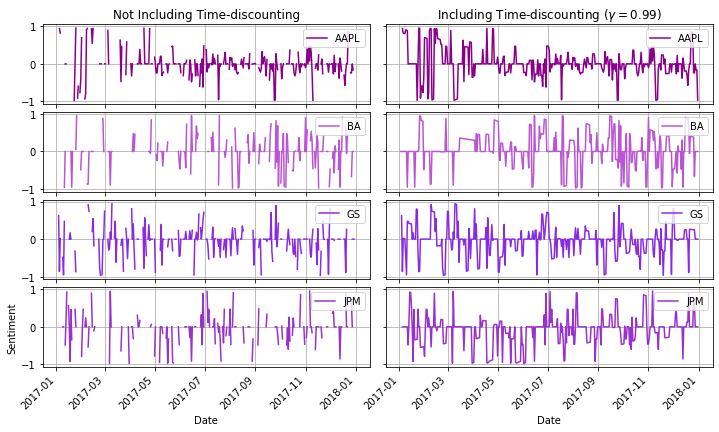

In [22]:
# make the imputation plots for all the gammas (put into appendix)
# toDO: have a closer look at BA after 2017-03 to really see how the decay factor influences behavior

gammas = [0.3, 0.5, 0.7, 0.9, 0.99]      # [0.3, 0.5, 0.7, 0.9, 0.99]
for gamma in gammas:
    make_imputation_plot(chosen4_sent, gamma)

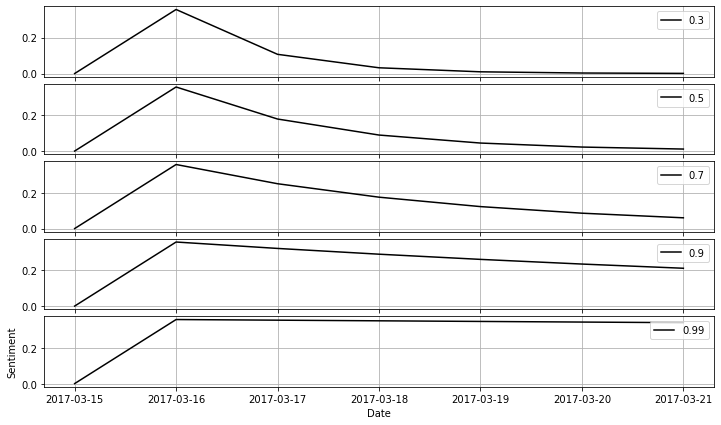

In [23]:
"""

modify plot function slightly to only show a particular days/months
"""
import copy

gammas = [0.3, 0.5, 0.7, 0.9, 0.99] 

fig = plt.figure(figsize=(12,7))
gs = fig.add_gridspec(nrows=len(gammas), hspace=0.1, wspace=0.05)
axs = gs.subplots(sharex=True, sharey=True)

 

for i, gamma in enumerate(gammas):
    imputed = copy.deepcopy(chosen4_sent) 
    imputed["BA"] =  discount_imputation(imputed["BA"], gamma)
    axs[i].plot(imputed["BA"]['sent_val'][(imputed["BA"].index.year == 2017) & (imputed["BA"].index.month == 3) & (imputed["BA"].index.day >= 15) & (imputed["BA"].index.day <= 21)], label=gamma, color='black')
    axs[i].grid()
    axs[i].legend(loc=1)

plt.xlabel('Date')
plt.ylabel('Sentiment')

plt.savefig('../files/experiment_outputs/gamma_decay.png')
plt.show()

In [24]:
# read in the excess returns dataframes for our four tickers and clean up data

'''

NOTE: we do not perform any imputations or other modification to the original data
'''

chosen4_ffc = {}
keys = ['AAPL', 'BA', 'GS', 'JPM']

for key in keys:
    # extract ticker
    chosen4_ffc[key] = ffc_df[ffc_df['TICKER'] == key]
    
    # set datetime column
    chosen4_ffc[key]['DATE'] = pd.to_datetime(chosen4_ffc[key]['DATE'])
    
    # set index
    chosen4_ffc[key] = chosen4_ffc[key].set_index('DATE')
    
    # filter out dates and sort
    chosen4_ffc[key] = chosen4_ffc[key][(chosen4_ffc[key].index.year > 2016) & (chosen4_ffc[key].index.year < 2022)]
    chosen4_ffc[key] = chosen4_ffc[key].sort_index(ascending=True)



C:\Users\SEBAST~1.KEI\AppData\Local\Temp/ipykernel_5088/1779245002.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chosen4_ffc[key]['DATE'] = pd.to_datetime(chosen4_ffc[key]['DATE'])


In [25]:
# peak at the data
chosen4_ffc['AAPL']

,PERMNO,n,RET,alpha,b_mkt,b_smb,b_hml,b_umd,ivol,tvol,R2,exret,TICKER
DATE,,,,,,,,,,,,,
2017-01-02,14593,252,0.061,0.001,0.925,-0.254,-0.560,-0.009,1.1334%,1.3214%,26.4262%,0.061,AAPL
2017-01-03,14593,252,0.020,0.001,0.961,-0.246,-0.568,0.059,1.0979%,1.2560%,23.5981%,0.011,AAPL
2017-01-05,14593,252,0.020,0.001,0.928,-0.188,-0.518,0.109,0.9723%,1.1247%,25.2732%,0.017,AAPL
2017-01-06,14593,252,0.003,0.001,0.981,-0.190,-0.511,0.226,0.9439%,1.1097%,27.6456%,-0.003,AAPL
2017-01-08,14593,252,0.009,0.001,0.953,-0.130,-0.537,0.480,0.8437%,1.0660%,37.3593%,0.004,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,14593,252,0.023,0.001,1.079,-0.350,-0.382,0.209,1.0624%,1.5992%,55.8643%,0.007,AAPL
2021-12-28,14593,252,-0.006,0.001,1.064,-0.335,-0.386,0.213,1.0455%,1.5850%,56.4895%,-0.001,AAPL
2021-12-29,14593,252,0.001,0.001,1.064,-0.348,-0.385,0.217,1.0423%,1.5823%,56.6142%,-0.001,AAPL


In [26]:
# match the sentiment and excess return values to create one dataframe for each company

'''
chosen4: cleaned dataframe that contains both sentiment and excess return columns
'''

chosen4 = {}
keys = ['AAPL', 'BA', 'GS', 'JPM']

for key in keys:
    chosen4[key] = pd.DataFrame()
    chosen4[key].index = chosen4_ffc[key].index
    chosen4[key]['exret'] = chosen4_ffc[key]['exret']
    chosen4[key]['sent_val'] = chosen4_sent[key]['sent_val']

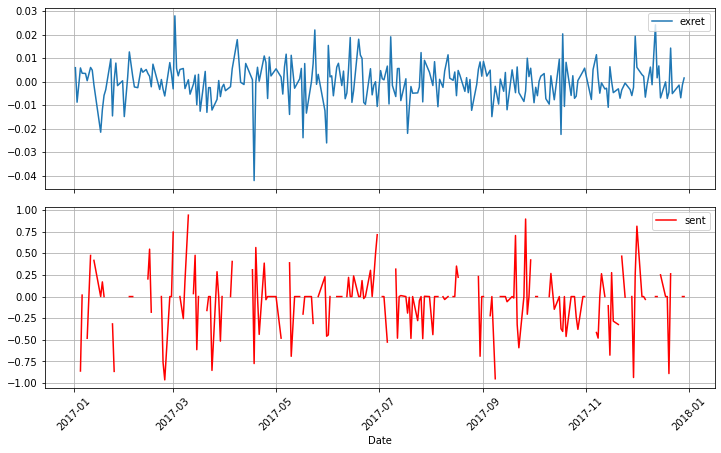

In [27]:
# make plot of sentiment vs. excess returns

'''

NOTE: we still have to put these somewhere in the thesis (Exploration part)

- show different samples for different stocks and years
'''

ticker = 'GS'
year = 2017
sample = chosen4[ticker][chosen4[ticker].index.year == year]

fig = plt.figure(figsize=(12,7))
gs = fig.add_gridspec(nrows=2, hspace=0.1)
axs = gs.subplots(sharex=True)

axs[0].plot(sample.exret, label='exret')
axs[1].plot(sample.sent_val, label='sent', color='red')
axs[0].grid()
axs[1].grid()
axs[0].legend(loc=1)
axs[1].legend(loc=1)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.savefig(f'../files/experiment_outputs/sentvsexret_{ticker}_{year}')
plt.show()


In [ ]:
# toDO: select some clever samples
# see what actually happened then in the news and reason how it might have effected returns

In [28]:
# measure correlation coefficients with no lag with un-imputed vs. imputed series
# purpose: study how these correlation change when we introduce the decay factor

'''
NOTE: in the thesis, this goes into Results -> gamma-optimization

'''

pd.set_option('display.float_format', lambda x: '%.3f' % x)

corr_res = {}    
corr_res['ticker'] = []
corr_res['no_gamma'] = []
corr_res['gamma03'] = []
corr_res['gamma05'] = []
corr_res['gamma07'] = []
corr_res['gamma09'] = []
corr_res['gamma099'] = []

for ticker in chosen4.keys():
    corr_res['ticker'].append(ticker)
    
    # calculate pearson coefficient for differnt configurations and store results
    nonull = chosen4[ticker].dropna()
    corr_res['no_gamma'].append(tuple([round(x, 4) for x in pearsonr(nonull.sent_val, nonull.exret)]))

    gamma03 = discount_imputation(chosen4[ticker], 0.3).dropna()
    corr_res['gamma03'].append(tuple([round(x, 4) for x in pearsonr(gamma03.sent_val, gamma03.exret)]))
    
    gamma05 = discount_imputation(chosen4[ticker], 0.5).dropna()
    corr_res['gamma05'].append(tuple([round(x, 4) for x in pearsonr(gamma05.sent_val, gamma05.exret)]))
    
    gamma07 = discount_imputation(chosen4[ticker], 0.7).dropna()
    corr_res['gamma07'].append(tuple([round(x, 4) for x in pearsonr(gamma07.sent_val, gamma07.exret)]))
    
    gamma09 = discount_imputation(chosen4[ticker], 0.9).dropna()
    corr_res['gamma09'].append(tuple([round(x, 4) for x in pearsonr(gamma09.sent_val, gamma09.exret)]))
    
    gamma099 = discount_imputation(chosen4[ticker], 0.99).dropna()
    corr_res['gamma099'].append(tuple([round(x, 4) for x in pearsonr(gamma099.sent_val, gamma099.exret)]))
    
corr_res_df = pd.DataFrame(corr_res)
corr_res_df = corr_res_df.set_index('ticker')

print(corr_res_df.T.to_latex(float_format="%.2f"))

\begin{tabular}{lllll}
\toprule
ticker &           AAPL &             BA &                GS &               JPM \\
\midrule
no\_gamma &  (0.1407, 0.0) &  (0.1995, 0.0) &  (0.0489, 0.1289) &  (0.1104, 0.0019) \\
gamma03  &  (0.1284, 0.0) &  (0.1784, 0.0) &   (0.046, 0.1032) &   (0.0872, 0.002) \\
gamma05  &  (0.1283, 0.0) &    (0.18, 0.0) &   (0.045, 0.1111) &   (0.0836, 0.003) \\
gamma07  &  (0.1281, 0.0) &  (0.1791, 0.0) &   (0.0425, 0.132) &  (0.0783, 0.0055) \\
gamma09  &  (0.1274, 0.0) &  (0.1741, 0.0) &  (0.0385, 0.1728) &  (0.0707, 0.0122) \\
gamma099 &  (0.1268, 0.0) &  (0.1695, 0.0) &  (0.0361, 0.2007) &  (0.0664, 0.0185) \\
\bottomrule
\end{tabular}



In [29]:
chosen4['AAPL']

,exret,sent_val
DATE,,
2017-01-02,0.061,NaN
2017-01-03,0.011,NaN
2017-01-05,0.017,0.938
2017-01-06,-0.003,0.817
2017-01-08,0.004,NaN
...,...,...
2021-12-27,0.007,0.292
2021-12-28,-0.001,-0.122
2021-12-29,-0.001,-0.625


In [30]:
'''
Construct master method: sets up data in a way that it can be used for machine learning
'''

def construct_master(df, gamma, maxlags, sent=True):
    '''
    df: dataframe extracted from the chosen4 dictionary, includes both sentiment and excess returns
    gamma: decay factor (based on choices made earlier)
    maxlags: the maximum number of lags that should be considered in the time series model, based on previous results tables
    '''
    
    # make a deep copy to avoid overwriting the original dataframe
    master_df = df.copy(deep=True)
    
    # perform discount imputation
    master_df = discount_imputation(master_df, gamma)
    
    # multiply excess returns * 100 to get percentages
    master_df['exret']  = master_df['exret'] * 100

    if sent==True:
    # enter lags for sentiment up until t-maxlags
        for i in range(1, maxlags):
            master_df[f'sent_t-{i}'] = master_df['sent_val'].shift(i)

    # include also excess returns up until t-maxlags
    for i in range(1, maxlags):
        master_df[f'exret_t-{i}'] = master_df['exret'].shift(i)
    
#     if not sent:
#         master_df = master_df.drop(['sent_val'])
    
    return master_df

In [31]:
# train-validation split that divides into 60% training and 40% validation (used in walk-forward manner)

def train_val_split(df_sub, val_perc):
    """
    df_sub: subset of dataframe that is split along time-axis (e.g., window of size 100 days)
    val_perc: percentage of validation set (e.g., 40%)
    """
    
    cut_off_idx = int((1-val_perc) * len(df_sub))
    
    train_set, val_set = df_sub[:cut_off_idx], df_sub[cut_off_idx:]
    X_train, y_train = train_set.iloc[:, 1:], train_set.iloc[:,0]
    X_val, y_val = val_set.iloc[:, 1:], val_set.iloc[:,0]
    
    return X_train, y_train, X_val, y_val

In [32]:
### WALK-FORWARD VALIDATION: EXCLUSIVE WINDOW-SHIFTING ###

'''
We have a window of size WIN_SIZE that we shift at each iteration, VAL_PERC gives validation percentage within this window,
after validating it is also given to the model for training

'''

def walk_forward_validation(model, dataset, win_size=100, val_perc=0.3):

    # store results
    val_rmse_curve = []
    val_mape_curve = []
    preds_vs_acts = []
    
    # basic training and validation loop (walk-forward manner)
    for i in range(0, len(dataset), win_size):
        # slice window
        df_sub = dataset[i:i+win_size]

        X_train, y_train, X_val, y_val = train_val_split(df_sub, val_perc)

        # fit the regressor on the training data and predict on validation data
        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        # append predictions vs actuals for each period
        preds_vs_acts.append((preds, y_val))

        # compute and store the RMSE error term
        rmse = mean_squared_error(y_val, preds, squared=False)
        val_rmse_curve.append(rmse)
        
        # compute and store the MAPE error term
        mape = mean_absolute_percentage_error(y_val, preds)
        val_mape_curve.append(mape)

        # give the validation set for training
        model.fit(X_val, y_val)

    return val_rmse_curve, val_mape_curve, preds_vs_acts

In [33]:
'''
Optimization to choose gamma's for our 4 companies

- keep maxlags fixed for now
- keep RF model parameters fixed for now
'''

### EXPERIMENT: OPTIMIZE FOR GAMMA FACTOR ###
# based on previous results, we choose Random Forest with 1000 num_trees, 5 max_depth

gammas = [0.3, 0.5, 0.7, 0.9, 0.99]
MAXLAG = 15

SEED = 423

# store results
gamma_opt_res = {}


# make stock selection (sentiment)
tickers = ['AAPL', 'BA', 'GS', 'JPM']

for ticker in tickers:
    
    # make new entry in results
    gamma_opt_res[ticker] = {}
    
    for gamma in gammas:
        
        # print statement to show progress
        print(f'Running experiment: gamma: {gamma}; stock: {ticker}')
        
        # filter out testing period (2021)
        df = chosen4[ticker][chosen4[ticker].index.year < 2021]
        
        # construct master dataframe
        dataset = construct_master(df, gamma, MAXLAG)
        
        # for random forest: drop all NaN values
        dataset = dataset.dropna()
    
        # initialize model (FIXED)
        model = RandomForestRegressor(n_estimators=1000, max_depth=5, random_state= SEED)
        
        # run walk-forward validation loop and collect results
        val_rmse_curve, val_mape_curve, _ = walk_forward_validation(model, dataset)
            
        # average results and store them
        gamma_opt_res[ticker][f'gamma:{gamma}'] = {}
        gamma_opt_res[ticker][f'gamma:{gamma}']['val_rmse'] = np.mean(val_rmse_curve)
        gamma_opt_res[ticker][f'gamma:{gamma}']['val_mape'] = np.mean(val_mape_curve)           


Running experiment: gamma: 0.3; stock: AAPL
Running experiment: gamma: 0.5; stock: AAPL
Running experiment: gamma: 0.7; stock: AAPL
Running experiment: gamma: 0.9; stock: AAPL
Running experiment: gamma: 0.99; stock: AAPL
Running experiment: gamma: 0.3; stock: BA
Running experiment: gamma: 0.5; stock: BA
Running experiment: gamma: 0.7; stock: BA
Running experiment: gamma: 0.9; stock: BA
Running experiment: gamma: 0.99; stock: BA
Running experiment: gamma: 0.3; stock: GS
Running experiment: gamma: 0.5; stock: GS
Running experiment: gamma: 0.7; stock: GS
Running experiment: gamma: 0.9; stock: GS
Running experiment: gamma: 0.99; stock: GS
Running experiment: gamma: 0.3; stock: JPM
Running experiment: gamma: 0.5; stock: JPM
Running experiment: gamma: 0.7; stock: JPM
Running experiment: gamma: 0.9; stock: JPM
Running experiment: gamma: 0.99; stock: JPM


In [34]:
# function format and display results for LATEX

def show_results(res_dict, latex=True):

    reform = {(outerKey, innerKey): values for outerKey, innerDict in res_dict.items() for innerKey, values in innerDict.items()}

    res_df = pd.DataFrame(reform)
    
    if latex:
        print(res_df.T.to_latex())
    
    else:
        print(res_df.T)

In [35]:
# illustrate results for the gamma optimization

show_results(gamma_opt_res)


\begin{tabular}{llrr}
\toprule
    &            &  val\_rmse &  val\_mape \\
\midrule
AAPL & gamma:0.3 &     1.298 &     4.101 \\
    & gamma:0.5 &     1.296 &     5.181 \\
    & gamma:0.7 &     1.299 &     4.641 \\
    & gamma:0.9 &     1.294 &     4.584 \\
    & gamma:0.99 &     1.282 &     4.420 \\
BA & gamma:0.3 &     2.079 &     1.913 \\
    & gamma:0.5 &     2.089 &     1.767 \\
    & gamma:0.7 &     2.102 &     1.744 \\
    & gamma:0.9 &     2.123 &     1.783 \\
    & gamma:0.99 &     2.133 &     1.808 \\
GS & gamma:0.3 &     1.218 &     2.150 \\
    & gamma:0.5 &     1.215 &     2.141 \\
    & gamma:0.7 &     1.213 &     2.193 \\
    & gamma:0.9 &     1.225 &     2.207 \\
    & gamma:0.99 &     1.229 &     2.208 \\
JPM & gamma:0.3 &     0.745 &     2.124 \\
    & gamma:0.5 &     0.746 &     2.187 \\
    & gamma:0.7 &     0.748 &     2.060 \\
    & gamma:0.9 &     0.761 &     2.174 \\
    & gamma:0.99 &     0.758 &     2.169 \\
\bottomrule
\end{tabular}



# Econometric Analysis

- for each ticker (all of them), we want to do the following:
    - compute ADFuller test-statistic and p-value for excess returns, to find out if the series is stationary
    - show the significant auto-correlation lags (p-values <= 0.05) for the excess returns component
    - show the signficant cross-correlations between excess returns and sentiment time-series (p-values <= 0.05)

In [36]:
# prepare sentiment and excess returns series for econometric analysis

'''
toDO: use the gammas best for each of 4 companies
    
- show full table in a gamma of 0.5 in the Appendix

'''

DISCOUNT_FACTOR = 0.5     #0.5
ea_sent = sent_dict_c.copy()
ea_ffc = {}

for key in ea_sent.keys():
    
    ### prepare FFC values by extracting, formatting datetime, filtering dates and sorting ###
    ea_ffc[key] = ffc_df[ffc_df['TICKER'] == key]
    ea_ffc[key]['DATE'] = pd.to_datetime(ea_ffc[key]['DATE'])
    ea_ffc[key]['exret'] = pd.to_numeric(ea_ffc[key]['exret'])
    ea_ffc[key] = ea_ffc[key].set_index('DATE')
    ea_ffc[key] = ea_ffc[key][(ea_ffc[key].index.year > 2016) & (ea_ffc[key].index.year < 2022)]
    ea_ffc[key] = ea_ffc[key].sort_index(ascending=True)
    
    ### prepare sentiment values and map them to the ea_ffc to match time index###
    #ea_sent[key] = discount_imputation(ea_sent[key], DISCOUNT_FACTOR)
    #ea_ffc[key]['sent_val'] = ea_sent[key]['sent_val']


C:\Users\SEBAST~1.KEI\AppData\Local\Temp/ipykernel_5088/2707420883.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ea_ffc[key]['DATE'] = pd.to_datetime(ea_ffc[key]['DATE'])
C:\Users\SEBAST~1.KEI\AppData\Local\Temp/ipykernel_5088/2707420883.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ea_ffc[key]['exret'] = pd.to_numeric(ea_ffc[key]['exret'])


In [37]:
# dictionary to store sector of all the companies
# source: https://finasko.com/dow-jones-companies-sector-weight/

sectors = {"AAPL": "Technology",
                "AMGN": "Healthcare",
                "AXP": "Financial Services",
                "BA": "Industrials",
                "CAT": "Industrials",
                "CSCO": "Technology",
                "CVX": "Energy",
                "GS": "Financial Services",
                "HD": "Consumer Cyclical",
                "HON": "Industrials",
                "IBM": "Technology",
                "INTC": "Technology",
                "KO": "Consumer Cyclical",
                "JPM": "Banks",
                "MCD": "Consumer Cyclical",
                "MMM": "General Industrials",
                "MRK": "Pharmaceuticals & Biotechnology",
                "MSFT": "Technology",
                "NKE": "Consumer Cyclical",
                "PG": "Consumer Cyclical",
                "TRV": "Financial Services",
                "UNH": "Healthcare",
                "CRM": "Technology",
                "VZ": "Communication Services",
                "V": "Financial Services",
                "WBA": "Healthcare",
                "WMT": "Consumer Cyclical",
                "DIS": "Communication Services",
                }

In [38]:
'''
function to run the ADF-fuller test on the target series (excess returns)
'''

def run_adf_fuller(df_ffc):
    result = adfuller(df_ffc.exret)
    return f"{result[0]:.2f} ({result[1]:.2f})" 

In [39]:
def find_var_lags(df_ffc):
    
    # drop NaNs to match the lengths of both series
    df_ffc = df_ffc.dropna()
    
    # correlation between ff_excess and sent
    # ff_excess is the y-variable here
    corr = []
    sign_corr = []    # significance of correlation

    for lag in range(1,30):
        # toDO: chech if these lags really work out
        ffc_series = df_ffc['exret'].iloc[lag:]
        lagged_sent_series = df_ffc['sent_val'].iloc[:-lag]
        res = pearsonr(ffc_series, lagged_sent_series)
        corr.append(res[0])
        sign_corr.append(res[1])
       
    res = []
    
    for i in range(len(corr)):
        if sign_corr[i] <= 0.05 and corr[i] < 0:
            res.append(f"{i+1}(-)")
                       
        elif sign_corr[i] <= 0.05 and corr[i] > 0:
            res.append(f"{i+1}(+)")
    
    return ",".join(res)

In [40]:
'''
function to find significant AR lags of the target series to model the AR component of the VAR model
'''

def find_ar_lags(df_ffc, nlags=30):
    # toDO: check if these lags really work out
    test_res = pacf(df_ffc['exret'], nlags=nlags, alpha=0.05)
    
    # estimate the 5% and 95% confidence bands
    cb = test_res[1][1] - test_res[0][1]
    
    # store results
    res = []
    
    # check if the computed auto-correlation is above or below the confidence intervals
    for i in range(1, len(test_res[0])):
        if test_res[0][i] < cb[0]:
            res.append(f'{i}(-)')
        elif test_res[0][i] > cb[1]:
            res.append(f'{i}(+)')
     
    print(res)
    return ",".join(res)

In [42]:
# build out results dataframe for the econometric ananlysis (VAR model building)

# results = {}
# results['ticker'] = []
# #results['sector'] = []
# results['ADF-fuller'] = []
# results['ar_lags'] = []
# results['var_lags'] = []
# #results['sparsity'] = []

# for key in ea_sent:
#     results['ticker'].append(key)
#     #results['sector'].append(sectors[key])
#     results['ADF-fuller'].append(run_adf_fuller(ea_ffc[key]))
#     results['ar_lags'].append(find_ar_lags(ea_ffc[key]))
#     results['var_lags'].append(find_var_lags(ea_ffc[key]))
#     #results['sparsity'].append(round(sparsity_ratios[key], 2))
    
# results_df = pd.DataFrame(results)
# results_df = results_df.set_index('ticker')

In [43]:
# transform to latex table

# print(results_df.to_latex())

In [44]:
# make same table but using only selected stocks and chosen discount rates

# build out results dataframe for the econometric ananlysis (VAR model building)

results = {}
results['ticker'] = []
#results['sector'] = []
results['ADF-fuller'] = []
results['ar_lags'] = []
results['var_lags'] = []
#results['sparsity'] = []

tickers = ['AAPL', 'BA', 'GS', 'JPM']

gammas =[0.3, 0.7, 0.5, 0.7]


for i, ticker in enumerate(tickers):
    # perform discount factor imputation
    ea_sent[ticker] = discount_imputation(ea_sent[ticker], gammas[i])
    ea_ffc[ticker]['sent_val'] = ea_sent[ticker]['sent_val']
    
    results['ticker'].append(ticker)
    #results['sector'].append(sectors[key])
    results['ADF-fuller'].append(run_adf_fuller(ea_ffc[ticker]))
    results['ar_lags'].append(find_ar_lags(ea_ffc[ticker]))
    results['var_lags'].append(find_var_lags(ea_ffc[ticker]))
    #results['sparsity'].append(round(sparsity_ratios[key], 2))
    
results_df = pd.DataFrame(results)
results_df = results_df.set_index('ticker')


['16(+)']
['1(+)', '2(+)', '3(-)', '4(-)', '5(-)', '6(-)', '21(-)', '22(-)']
['12(-)', '27(+)']
['2(+)', '4(-)', '5(+)', '11(+)', '15(-)']


In [45]:
# transform to latex table

print(results_df.to_latex())

\begin{tabular}{llll}
\toprule
{} &     ADF-fuller &                                    ar\_lags &               var\_lags \\
ticker &                &                                            &                        \\
\midrule
AAPL   &  -34.58 (0.00) &                                      16(+) &                  24(-) \\
BA     &  -18.47 (0.00) &  1(+),2(+),3(-),4(-),5(-),6(-),21(-),22(-) &  1(+),2(+),14(+),19(-) \\
GS     &  -35.59 (0.00) &                                12(-),27(+) &                        \\
JPM    &   -9.12 (0.00) &                 2(+),4(-),5(+),11(+),15(-) &                        \\
\bottomrule
\end{tabular}



## C03.2 VAR fitting

In [46]:
# suppress warnings for the experiments

import warnings
warnings.filterwarnings('ignore')

In [47]:
'''

make VAR summary statistics for our 4 companies
- NOTE: these can go into the Appendix, if we need them at all
'''

# define the maximum number of lags we want to investigate
mls = [24, 22, 27, 15]    # maxlags for AAPL, BA, GS and JPM (based on previous results tables)

summaries = []

for i,ticker in enumerate(chosen4.keys()):

    # set up our dataframe for the VAR
    var_df = discount_imputation(chosen4[ticker], 0.5).dropna()

    # take out the year 2021, as this is used for testing
    var_df = var_df[var_df.index.year < 2021]

    # initialize the model
    model = VAR(var_df)

    # fit the model, specifying the maximum lags under investigation
    model_fit = model.fit(maxlags=mls[i])

    # save the summaries
    summaries.append(model_fit.summary())

In [48]:
'''
walk-forward validation for the VAR
- we use a enlargening window approach, rather than sliding window approach
- we use a fixed-size validation window (e.g., 5 days), rather than a percentage of the window

'''

def var_wf(var_df, win_size, val_size, maxlags):
    '''
    var_df: dataframe with two columns (sent and excess returns) that have been formatted for the VAR
    win_size: the size of the sliding window
    val_size: the size of the validation window
    maxlags: maximum lags parameter as found by the previous experiments
    '''
    
    # storage for the results
    rmse_curve = []
    mape_curve = []

    # initialize the dataset for VAR format
    #var_df = pd.DataFrame()
    #var_df['exret'] = ffc_df['exret']
    #var_df['sent'] = sent_df['sent_val']
    #var_df = var_df[var_df.index.year < 2022]
    #var_df = var_df.dropna()

    # store predictions vs. actuals for plotting
    pred_vs_act = []
    
    # basic training and validation loop (walk-forward manner)
    for i in range(0, len(var_df)-win_size, win_size):    # step-size: win-size

        # slice window
        df_sub = var_df[:i+win_size]

        # split into training and validation sets
        #cut_off_idx = int((1-VAL_PERC) * len(df_sub))
        
        train_set, val_set = df_sub[:-val_size], df_sub[-val_size:]

        # only in the first iteration: initiliaze the VAR model
        model = VAR(train_set)

        # fit the VAR model
        model_fitted = model.fit(maxlags)

        # Get the lag order
        lag_order = model_fitted.k_ar

        # make forecast
        nobs = len(val_set)
        forecast_input = df_sub.values[-lag_order:]
        fc = model_fitted.forecast(y=forecast_input, steps=nobs)
        df_forecast = pd.DataFrame(fc, index=df_sub.index[-nobs:], columns=df_sub.columns + '_1d')
        preds = df_forecast['exret_1d']
        df_forecast['actuals'] = val_set['exret']

        # record the RMSE error
        rmse = mean_squared_error(df_forecast['actuals'], df_forecast['exret_1d'], squared=False)
        rmse_curve.append(rmse)
        
        # record the MAPE error
        mape = mean_absolute_percentage_error(df_forecast['actuals'], df_forecast['exret_1d'])
        mape_curve.append(mape)
        
        # store predictions vs. actuals as tuples
        pred_vs_act.append(df_forecast)
        
    return rmse_curve, mape_curve, pred_vs_act


In [49]:
# use function for all tickers

# define the maximum number of lags we want to investigate
mls = [24, 22, 27, 15]    # maxlags for AAPL, BA, GS and JPM (based on previous results tables)

# define decay factor
gammas = [0.3, 0.7, 0.5, 0.7]                  # chosen based on the results table from gamma optimization

# store results
var_rmse = {}
var_mape = {}

# store predictions vs. actuals
pred_vs_act_dict = {}

for i, ticker in enumerate(chosen4.keys()):
    # prepare sentiment dataframe
    var_df = discount_imputation(chosen4[ticker], gammas[i]).dropna()

    # compute walk-forward validation using VAR
    rmse_curve, mape_curve, pred_vs_act = var_wf(var_df, win_size=40, val_size=10, maxlags=mls[i])
    
    # store results and fitted model
    var_rmse[ticker] = rmse_curve
    var_mape[ticker] = mape_curve
    pred_vs_act_dict[ticker] = pred_vs_act

In [50]:
# RESULT 1: make results overview table for the VAR 

pd.set_option('display.float_format', lambda x: '%.3f' % x)

var_res = {}
var_res['ticker'] = []
var_res['rmse'] = []
var_res['mape'] = []

for ticker in var_rmse.keys():
    var_res['ticker'].append(ticker)
    var_res['rmse'].append(np.mean(var_rmse[ticker]) * 100)
    var_res['mape'].append(np.mean(var_mape[ticker]))
    
    
print(pd.DataFrame(var_res).to_latex())

\begin{tabular}{llrr}
\toprule
{} & ticker &  rmse &  mape \\
\midrule
0 &   AAPL & 1.250 & 4.211 \\
1 &     BA & 1.661 & 2.290 \\
2 &     GS & 1.119 & 2.131 \\
3 &    JPM & 0.757 & 2.166 \\
\bottomrule
\end{tabular}



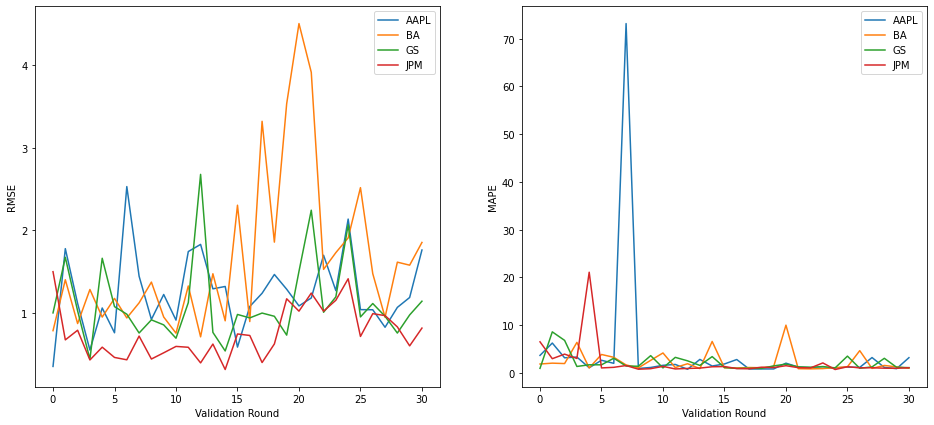

In [51]:
# plot the validation RMSE and MAPE curve for all 4 stocks

fig = plt.figure(figsize=(16,7))
gs = fig.add_gridspec(ncols=2)
axs = gs.subplots()

for i, ticker in enumerate(var_rmse.keys()):
    axs[0].plot([v*100 for v in var_rmse[ticker]], label=f'{ticker}')
    axs[1].plot([v for v in var_mape[ticker]], label=f'{ticker}')
    axs[0].grid()
    axs[1].grid()
    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel('Validation Round')
    axs[1].set_xlabel('Validation Round')
    axs[0].set_ylabel('RMSE')
    axs[1].set_ylabel('MAPE')


plt.savefig('../files/experiment_outputs/var_rmse.png')
plt.show()

In [53]:
# plot the actuals vs. predicted from VAR Model for a few selected intervals

def plot_var_predvsact(pred_vs_act_dict, index):
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(nrows=len(pred_vs_act_dict.keys()), ncols=1)
    axs = gs.subplots()

    for i, ticker in enumerate(pred_vs_act_dict.keys()):
        axs[i].plot(pred_vs_act_dict[ticker][index]['exret_1d'], label=f"{ticker}_pred")
        axs[i].plot(pred_vs_act_dict[ticker][index]['actuals'],  label=f"{ticker}_act")
        axs[i].grid()
        axs[i].legend()
        
    plt.ylabel('Sentiment')
    plt.xlabel('Date')
    plt.savefig(f'../files/experiment_outputs/var_predvsact_{index}.png')
    plt.show()

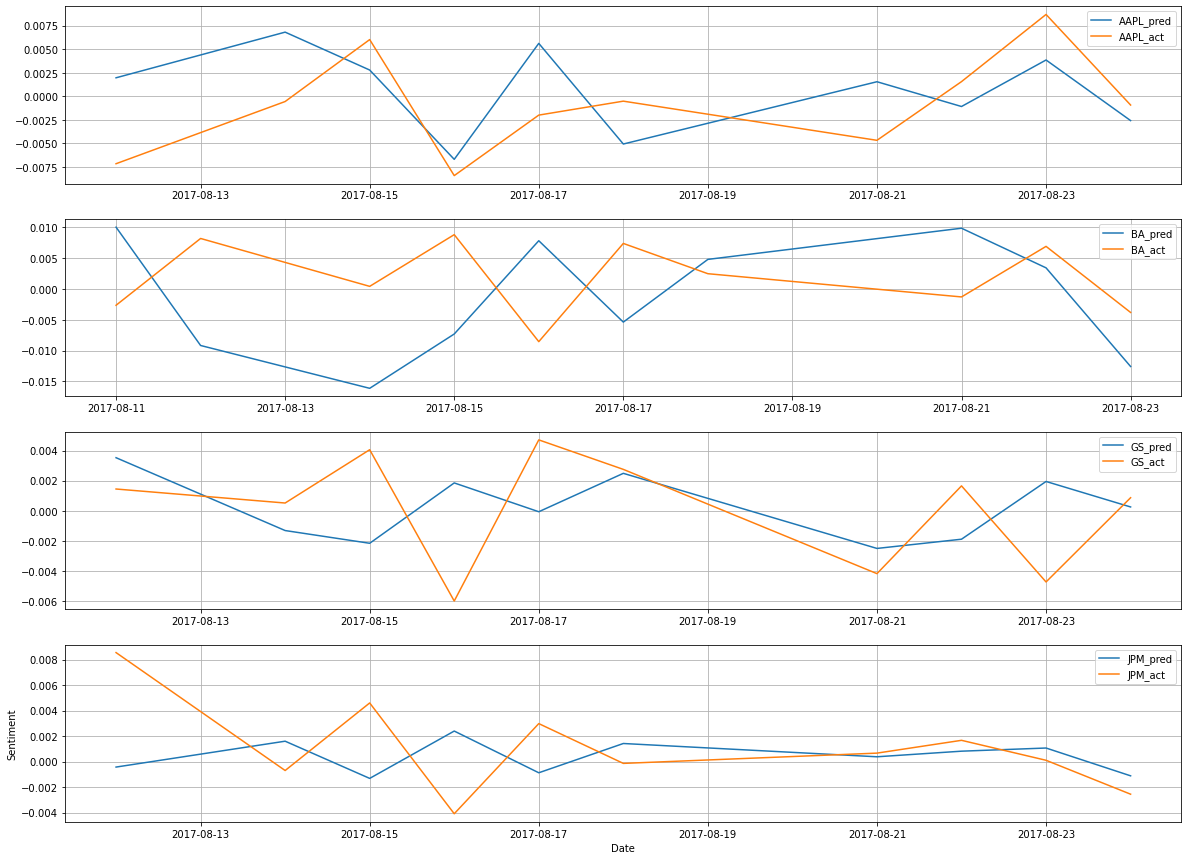

In [54]:
# use plotting function on a few collected instances
# index can be up to 30

plot_var_predvsact(pred_vs_act_dict, 3)

# ***Random Forest Optimization***

In [55]:
### EXPERIMENT: OPTIMIZING RANDOM FOREST REGRESSOR; fix gamma at 0.5 for now ###

max_depths = [5, 10, 15]
num_trees = [500, 1000, 1500]

SEED = 423

# define decay factor
gammas = [0.3, 0.7, 0.5, 0.7]                  # chosen based on the results table from gamma optimization

# define the maximum number of lags we want to investigate
mls = [24, 22, 27, 15]  # maxlags for AAPL, BA, GS and JPM (based on previous results tables)

# store results
rf_opt_res = {}

# store predictions vs. actuals for each ticker and configuration
preds_vs_acts_dict = {}


# store validation curves for all tickers

val_curves = {}

for i, ticker in enumerate(chosen4.keys()):
    
    # make new entry in results
    rf_opt_res[ticker] = {}
    preds_vs_acts_dict[ticker] = {}
    
    # filter out testing period (2021)
    df = chosen4[ticker][chosen4[ticker].index.year < 2021]

    # construct master dataframe
    dataset = construct_master(df, gammas[i], mls[i])
    
    # for random forest: drop all NaN values
    dataset = dataset.dropna()
    
    # filter out dates before 2021
    sent_df = dataset[dataset.index.year < 2021]
    
    for md in max_depths:
        for nt in num_trees:
            # print statement to show progress
            print(f'Running experiment: num_trees:{nt}; max_depth:{md}; stock: {ticker}')
            
            # initialize model
            model = RandomForestRegressor(n_estimators=nt, max_depth=md, random_state=SEED)
            
            # run walk-forward validation loop and collect results
            val_rmse_curve, val_mape_curve, preds_vs_acts = walk_forward_validation(model, dataset)
            
            # average results and store them
            rf_opt_res[ticker][f'num_trees:{nt}_max_depth:{md}'] = {}
            rf_opt_res[ticker][f'num_trees:{nt}_max_depth:{md}']['val_rmse'] = np.mean(val_rmse_curve)
            rf_opt_res[ticker][f'num_trees:{nt}_max_depth:{md}']['val_mape'] = np.mean(val_mape_curve)
            
            rf_opt_res[ticker][f'num_trees:{nt}_max_depth:{md}']['rmse_curve'] = val_rmse_curve
            rf_opt_res[ticker][f'num_trees:{nt}_max_depth:{md}']['mape_curve'] = val_mape_curve
            
            preds_vs_acts_dict[ticker][f'num_trees:{nt}_max_depth:{md}'] = preds_vs_acts
            

Running experiment: num_trees:500; max_depth:5; stock: AAPL
Running experiment: num_trees:1000; max_depth:5; stock: AAPL
Running experiment: num_trees:1500; max_depth:5; stock: AAPL
Running experiment: num_trees:500; max_depth:10; stock: AAPL
Running experiment: num_trees:1000; max_depth:10; stock: AAPL
Running experiment: num_trees:1500; max_depth:10; stock: AAPL
Running experiment: num_trees:500; max_depth:15; stock: AAPL
Running experiment: num_trees:1000; max_depth:15; stock: AAPL
Running experiment: num_trees:1500; max_depth:15; stock: AAPL
Running experiment: num_trees:500; max_depth:5; stock: BA
Running experiment: num_trees:1000; max_depth:5; stock: BA
Running experiment: num_trees:1500; max_depth:5; stock: BA
Running experiment: num_trees:500; max_depth:10; stock: BA
Running experiment: num_trees:1000; max_depth:10; stock: BA
Running experiment: num_trees:1500; max_depth:10; stock: BA
Running experiment: num_trees:500; max_depth:15; stock: BA
Running experiment: num_trees:1000

In [56]:
# show results table

show_results(rf_opt_res)

\begin{tabular}{llllll}
\toprule
    &                             & val\_rmse & val\_mape &                                         rmse\_curve &                                         mape\_curve \\
\midrule
AAPL & num\_trees:500\_max\_depth:5 &    1.317 &    3.287 &  [0.7048968604759466, 0.9991510467412461, 1.191... &  [1.8664323428362293, 2.9811056637512534, 12.81... \\
    & num\_trees:1000\_max\_depth:5 &    1.315 &    3.396 &  [0.700515285253833, 1.0062956369702927, 1.1824... &  [1.8322691171625454, 2.97014367476297, 13.8700... \\
    & num\_trees:1500\_max\_depth:5 &    1.315 &    3.121 &  [0.7010422152991732, 1.0103496717909528, 1.181... &  [1.7979210285908616, 2.9879581031859934, 10.98... \\
    & num\_trees:500\_max\_depth:10 &    1.319 &    3.011 &  [0.7102293520336229, 0.9972683818809459, 1.204... &  [1.9370791690410962, 3.0913277074391075, 9.126... \\
    & num\_trees:1000\_max\_depth:10 &    1.317 &    3.288 &  [0.70602882090743, 1.0049552228221423, 1.19277... &  [1.889

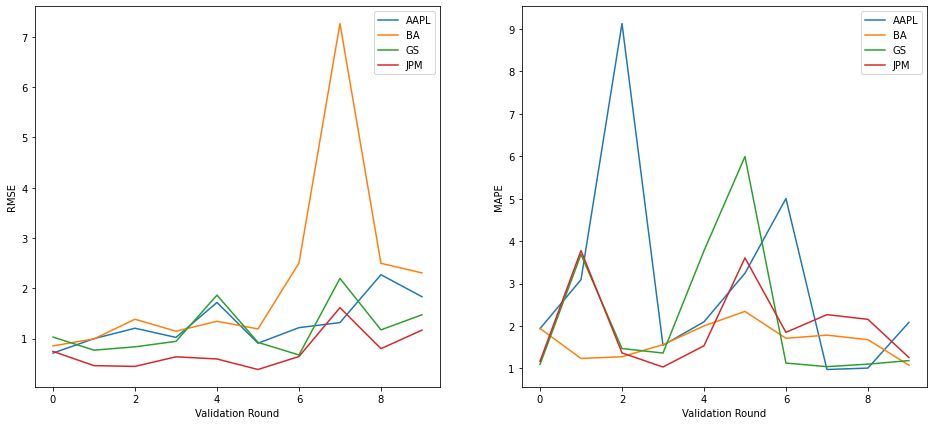

In [57]:
# plot the validation RMSE and MAPE curve for all 4 stocks

fig = plt.figure(figsize=(16,7))
gs = fig.add_gridspec(ncols=2)
axs = gs.subplots()

optimal_models = {
    'AAPL': 'num_trees:500_max_depth:10',
    'BA': 'num_trees:1500_max_depth:5',
    'GS': 'num_trees:1500_max_depth:5',
    'JPM':'num_trees:500_max_depth:5'}

for i, ticker in enumerate(preds_vs_acts_dict.keys()):
    axs[0].plot(rf_opt_res[ticker][optimal_models[ticker]]['rmse_curve'], label=f'{ticker}')
    axs[1].plot(rf_opt_res[ticker][optimal_models[ticker]]['mape_curve'], label=f'{ticker}')
    axs[0].grid()
    axs[1].grid()
    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel('Validation Round')
    axs[1].set_xlabel('Validation Round')
    axs[0].set_ylabel('RMSE')
    axs[1].set_ylabel('MAPE')


plt.savefig('../files/experiment_outputs/rf_rmse_mape.png')
plt.show()

In [58]:
# plot the actuals vs. predicted from Random Forest Model for a few selected intervals

def plot_rf_predvsact(pred_vs_act_dict, idx):
    
    optimal_models = {
        'AAPL': 'num_trees:500_max_depth:10',
        'BA': 'num_trees:1500_max_depth:5',
        'GS': 'num_trees:1500_max_depth:5',
        'JPM':'num_trees:500_max_depth:5'}
    
    
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(nrows=len(pred_vs_act_dict.keys()), ncols=1)
    axs = gs.subplots()

    for i, ticker in enumerate(pred_vs_act_dict.keys()):
        axs[i].plot(preds_vs_acts_dict[ticker][optimal_models[ticker]][idx][1].index,preds_vs_acts_dict[ticker][optimal_models[ticker]][idx][0], label=f'{ticker}_pred')
        axs[i].plot(preds_vs_acts_dict[ticker][optimal_models[ticker]][idx][1].index,preds_vs_acts_dict[ticker][optimal_models[ticker]][idx][1], label=f'{ticker}_act')

        axs[i].grid()
        axs[i].legend()
        
    plt.ylabel('Excess returns (in %)')
    plt.xlabel('Date')
    plt.savefig(f'../files/experiment_outputs/rf_predvsact_{idx}.png')
    plt.show()

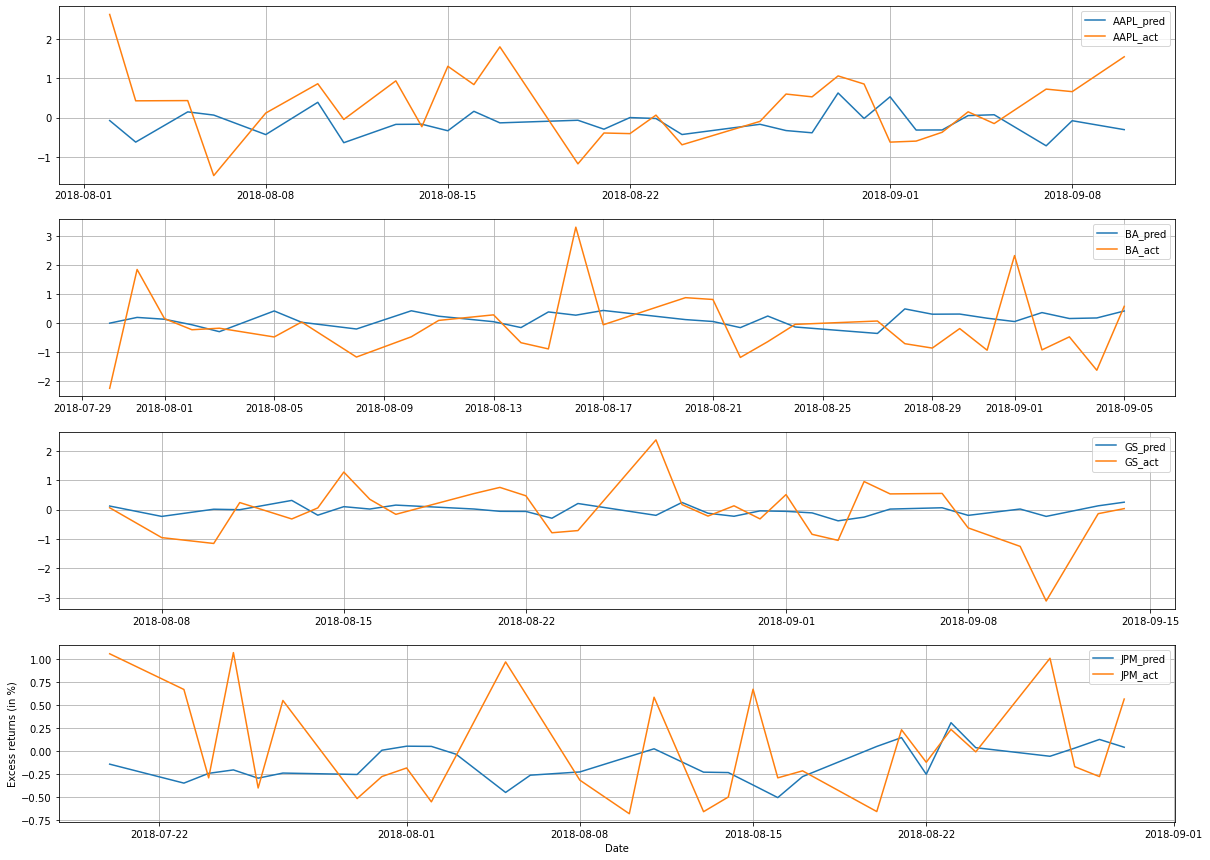

In [59]:
plot_rf_predvsact(pred_vs_act_dict, 3)

# ***Execute Trading Strategy (using RF)***

In [60]:
### train model on the historical data  ###

def train_model(ticker, chosen4, gamma, maxlags, n_estimators, max_depth):

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)

    # take out training sample
    rf_df = chosen4[ticker][chosen4[ticker].index.year < 2021]

    # perform imputation
    #rf_df = discount_imputation(rf_df, gamma)

    # construct master dataframe
    dataset = construct_master(rf_df, gamma, maxlags)

    # filter out NaNs
    dataset = dataset.dropna()

    # select X and y variables
    X, y = dataset.iloc[:, 1:],  dataset.iloc[:, 0]

    # fit the model on all the historical data
    model.fit(X, y)
    
    return model

In [61]:
def prep_pricedata(price_df, model, ticker, chosen4, gamma, maxlags):
    
    
    # set datetime index for the OHLC series
    price_df['Date'] = pd.to_datetime(price_df['Date'])
    price_df = price_df.set_index('Date')
    
    
    # perform filter operations on excess returns/sentiment dataframe
    df_2021 = chosen4[ticker][chosen4[ticker].index.year >= 2021].copy(deep=True)
    

    # make sure price_df index matches the one we already cleaned up excess returns and sentiment (only trading days)
    df_2021['Open'] = price_df['Open']
    df_2021['Close'] = price_df['Close']
    
    print(df_2021)
    
    # make column for predicted return
    #df_2021['pred_ret'] = df_2021.apply(lambda x: x.RET - x.exret, axis=1)

    # fill out missing dates for AAPL prices
    #all_dates = pd.date_range(start='01-01-2021', end='31-12-2021')
    #price_df = price_df.reindex(all_dates)
    #price_df = price_df.fillna(method='ffill')

    # concatenate and clean up 
    #price_df['ffc_pred_ret'] = df_2021['pred_ret']
    
    # perform imputation
    df_2021 = discount_imputation(df_2021, gamma)

    # construct master dataframe
    test_set = construct_master(df_2021, gamma, maxlags)

    # drop missing values
    test_set = test_set.dropna()

    # extract X variable only
    test_X = test_set.iloc[:, 1:]
    
    
    #### toDO: cast predictions in a way that walk-forward validation is used
    
    
    
    # cast predictions
    preds = [np.nan]*11 + list(model.predict(test_X))

    # append excess return predictions to our price series 
    price_df['sent_pred_ret'] = preds
    
    # make column for the predicted price

    # predicted price (t) = Prev_close * (FFC_prediction  + sent_prediction)

    # cast predictions for prices
    price_df['predicted_close'] = price_df['Close'].shift(1) * (1 + (price_df['ffc_pred_ret'] + price_df['sent_pred_ret']/100))

    # drop missing values
    price_df = price_df.dropna()

    # add returns column
    price_df['ret'] = price_df['Open'].pct_change()
    
    return price_df

In [62]:
from math import floor

def run_trading_strategy(price_df):

    capital = 10000
    invested_capital = 0

    total_balance = []

    current_position = 'N'      # N: neutral, S: short, L: long

    stocks_owned = 0       # number of stocks we own
    stocks_shorted = 0     # number of stocks we have shorted

    for i, row in price_df.iterrows():

        # print some summary stats:

        #print(f'Current position: {current_position}')

        #print(f'Predicted close: {row["predicted_close"]}')
        #print(f'Current open: {row["Open"]}')


        ### if we have invested capital, get the return on that capital ###

        # if we are long, we earn the returns on the capital we own
        if current_position == 'L':
            invested_capital = (1 + row['ret']) * invested_capital
            #print(f'New invested capital: {invested_capital}')
            total_balance.append(invested_capital + capital)

        # if we are short, we earn the returns on the 'negative' returns
        if current_position == 'S':
            invested_capital = (1 - row['ret']) * invested_capital
            #print(f'New invested capital: {invested_capital}')
            total_balance.append(invested_capital + capital)

        ### checking for next trades ###
        # if close is higher than open + 1%, go long in the stock
        if row['predicted_close'] > (1.01 * row['Open']):

            # if we don't have any position, we go long 
            if current_position == 'N':

                # calculate number of stocks we can buy
                num_stocks = floor(capital/row['Open'])
                #print(f'We can buy {num_stocks} stocks.')

                # buy stock: reduce the capital by the amount we invested in and add to invested_capital
                capital -= num_stocks * row['Open']
                invested_capital += num_stocks * row['Open']

                # update the current position to long
                current_position = 'L'

                # update the number of stocks we own
                stocks_owned = num_stocks

            # if we are already long, stay long
            elif current_position == 'L':
                continue

            # if we are short, liquidate position and go long
            elif current_position == 'S':

                # sell shorted stock: increase our invested_capital and add it to our capital
                capital += stocks_shorted * row['Open']
                invested_capital -= stocks_shorted * row['Open']

                # buy stock 
                # calculate number of stocks we can buy
                num_stocks = floor(capital/row['Open'])
                #print(f'We can buy {num_stocks} stocks.')

                # buy stock: reduce the capital by the amount we invested in and add to invested_capital
                capital -= num_stocks * row['Open']
                invested_capital += num_stocks * row['Open']

        # if predicted close is smaller than open - ERROR MARGIN: go short
        elif row['predicted_close'] < (0.99 * row['Open']):

            # if we don't have any position, go short
            if current_position == 'N':

                # calculate number of stocks we can short
                num_stocks = floor(capital/row['Open'])
                #print(f'We can short {num_stocks} stocks.') 

                # short stock: reduce the capital by the amount we invested in and add to invested_capital
                capital -= num_stocks * row['Open']
                invested_capital += num_stocks * row['Open']

                # update the current position to short
                current_position = 'S'

                # update the number of stocks we shorted
                stocks_shorted = num_stocks

            # if we are already short, stay short
            elif current_position == 'S':
                continue

            # if we are long, liquidate position and go short
            elif current_position == 'L':

                # sell long stock: increase our invested_capital and add it to our capital
                capital += stocks_owned * row['Open']
                invested_capital -= stocks_owned * row['Open']

                # short stock 
                # calculate number of stocks we can short
                num_stocks = floor(capital/row['Open'])
                #print(f'We can short {num_stocks} stocks.') 

                # short stock: reduce the capital by the amount we invested in and add to invested_capital
                capital -= num_stocks * row['Open']
                invested_capital += num_stocks * row['Open']

                # update the current position to short
                current_position = 'S'

                # update the number of stocks we shorted
                stocks_shorted = num_stocks 
                
    return total_balance

In [63]:
# load in historical price data

aapl_prices = pd.read_csv('../files/external/price_data/AAPL.csv')
ba_prices = pd.read_csv('../files/external/price_data/BA.csv')
gs_prices = pd.read_csv('../files/external/price_data/GS.csv')
jpm_prices = pd.read_csv('../files/external/price_data/JPM.csv')

prices_data = [aapl_prices, ba_prices, gs_prices, jpm_prices]

In [64]:
### toDO: modify walk-forward validation in a way that it returns an array of predictions,

### casting a few predictions and then retraining the model...

def wf_predictions(model, test_X, test_y, win_size):
        
    # store predictions
    preds = []
    
    # basic training and validation loop (walk-forward manner)
    for i in range(0, test_X.shape[0], win_size):
        
        # slice window
        X_sub = test_X[i:i+win_size]
        y_sub = test_y[i:i+win_size]

        # cast predictions for window
        win_preds = model.predict(X_sub)
        
        # concatenate to all predictions
        preds += list(win_preds)

        # fit model on the window
        model.fit(X_sub, y_sub)
        
    return preds


In [65]:
chosen4["AAPL"]

,exret,sent_val
DATE,,
2017-01-02,0.061,NaN
2017-01-03,0.011,NaN
2017-01-05,0.017,0.938
2017-01-06,-0.003,0.817
2017-01-08,0.004,NaN
...,...,...
2021-12-27,0.007,0.292
2021-12-28,-0.001,-0.122
2021-12-29,-0.001,-0.625


In [135]:
chosen4_ffc['BA']

,PERMNO,n,RET,alpha,b_mkt,b_smb,b_hml,b_umd,ivol,tvol,R2,exret,TICKER
DATE,,,,,,,,,,,,,
2017-01-02,19561,252,0.003,0.000,0.983,-0.083,0.437,-0.174,0.9740%,1.3101%,44.7307%,0.004,BA
2017-01-03,19561,252,0.020,0.001,0.992,-0.042,0.379,-0.072,0.8760%,1.1578%,42.7539%,0.005,BA
2017-01-05,19561,252,-0.013,0.001,1.036,-0.087,0.354,-0.100,0.8288%,1.1145%,44.6905%,-0.014,BA
2017-01-06,19561,252,-0.002,0.001,1.044,-0.059,0.285,-0.122,0.8044%,1.0852%,45.0471%,-0.012,BA
2017-01-08,19561,252,-0.012,0.002,1.039,-0.204,0.049,-0.060,1.0084%,1.1342%,20.9569%,-0.015,BA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,19561,252,-0.005,-0.002,1.396,0.707,0.533,-0.014,1.6268%,2.2608%,48.2228%,-0.023,BA
2021-12-28,19561,252,0.015,-0.002,1.399,0.697,0.538,-0.015,1.6310%,2.2625%,48.0300%,0.018,BA
2021-12-29,19561,252,-0.012,-0.002,1.401,0.717,0.535,-0.023,1.6290%,2.2637%,48.2189%,-0.013,BA


In [134]:
chosen4['BA']

,exret,sent_val
DATE,,
2017-01-02,0.004,NaN
2017-01-03,0.005,0.000
2017-01-05,-0.014,NaN
2017-01-06,-0.012,0.000
2017-01-08,-0.015,NaN
...,...,...
2021-12-27,-0.023,NaN
2021-12-28,0.018,0.000
2021-12-29,-0.013,0.000


In [66]:
### RUN TRADING STRATEGY (FINAL VERSION !!) ###

# set sent to True/False to include/exclude sentiment features

SEED = 423

# define decay factor
gammas = [0.3, 0.7, 0.5, 0.7]                  # chosen based on the results table from gamma optimization

# define the maximum number of lags we want to investigate
mls = [24, 22, 27, 15]  # maxlags for AAPL, BA, GS and JPM (based on previous results tables)

num_trees = [500, 1500, 1500, 500]

max_depths = [10, 5, 5, 5]

# store price dfs 
price_dfs = {}

# store results
ts_results = {}

for i, ticker in enumerate(chosen4.keys()):
    
    print(f'Preparing and running strategy for {ticker}')
    
    # initialize model
    model = RandomForestRegressor(n_estimators=num_trees[i], max_depth=max_depths[i], random_state=SEED)   # initialize model
    
    # take out training sample
    rf_df = chosen4[ticker][chosen4[ticker].index.year < 2021]
    
    # construct master dataframe
    dataset = construct_master(rf_df, gammas[i], mls[i], sent=False)                 # this also performs discount imputation
    
    # # filter out NaNs
    dataset = dataset.dropna()
    
    # # select X and y variables
    X, y = dataset.iloc[:, 1:],  dataset.iloc[:, 0]
    
    # # fit the model on all the historical data
    model.fit(X, y)
    
    # extract price dataframe
    ohlc_df = prices_data[i]
    
    
    # transform prices darta
    ohlc_df['Date'] = pd.to_datetime(ohlc_df['Date'])
    ohlc_df =ohlc_df.set_index('Date')
    
    #print('OHLC Dataframe')
    #print(ohlc_df)

    # extract dataset for random forest predictions
    rf_2021 = chosen4[ticker][chosen4[ticker].index.year == 2021].copy(deep=True)

    #print('2021 Random Forest sample')
    #print(rf_2021)
    
    # # construct master dataframe for testset
    test_set = construct_master(rf_2021, gammas[i], mls[i], sent=False)
    
    # # drop missing values
    test_set = test_set.dropna()
    
    # # extract X variable only
    test_X = test_set.iloc[:, 1:]
    test_y = test_set.iloc[:, 0]
    
    # toDO: cast predictions using walk-forward manner
    preds = wf_predictions(model, test_X, test_y, 5)

    # # put everthing together in one dataframe
    price_df = chosen4[ticker][chosen4[ticker].index.year == 2021].copy(deep=True)
    #print('Price dataframe before any mapping')
    #print(price_df)
    
    
    price_df['Open'] = ohlc_df['Open']
    price_df['Close'] = ohlc_df['Close']
    price_df['ffc_pred_ret'] = chosen4_ffc[ticker].apply(lambda x: x.RET - x.exret, axis=1)
    
    # pad predictions
    
    preds = [np.nan]*(len(price_df) - len(preds)) + preds
    
#     if ticker == 'JPM':
#         preds = [np.nan]*(mls[i]) + preds
        
#     else:
#         preds = [np.nan]*(mls[i]+1) + preds
        
        
    # # append excess return predictions to our price series 
    price_df['sent_pred_ret'] = preds

    # # make column for the predicted price
    ### predicted price (t) = Prev_close * (FFC_prediction  + sent_prediction)  ###

    # # cast predictions for prices
    price_df['predicted_close'] = price_df['Close'].shift(1) * (1 + (price_df['ffc_pred_ret'] + price_df['sent_pred_ret']/100))

    # # drop missing values
    
    print('price_df before dropping nans')
    print(price_df)
    #price_df = price_df.iloc[mls[i]:, :]

    # # add returns column
    price_df['ret'] = price_df['Open'].pct_change()
    
    #print('price df!')
    #print(price_df)
    price_dfs[ticker] = price_df
    
    # RUN THE TRADING STRATEGY
    balance = run_trading_strategy(price_df)

    
    
    # store results
    ts_results[ticker] = balance

Preparing and running strategy for AAPL
price_df before dropping nans
            exret  sent_val    Open   Close  ffc_pred_ret  sent_pred_ret  \
DATE                                                                       
2021-01-02 -0.007       NaN     NaN     NaN         0.024            NaN   
2021-01-03  0.025       NaN     NaN     NaN         0.029            NaN   
2021-01-04 -0.010    -0.970 133.520 129.410         0.017            NaN   
2021-01-06  0.004    -0.639 127.720 126.600        -0.007            NaN   
2021-01-07 -0.001     0.210 128.360 130.920         0.003            NaN   
...           ...       ...     ...     ...           ...            ...   
2021-12-27  0.007     0.292 177.090 180.330         0.016         -0.350   
2021-12-28 -0.001    -0.122 180.160 179.290        -0.005          0.047   
2021-12-29 -0.001    -0.625 179.330 179.380         0.001          0.280   
2021-12-30 -0.004    -0.952 179.470 178.200        -0.003          0.085   
2021-12-31  0.001 

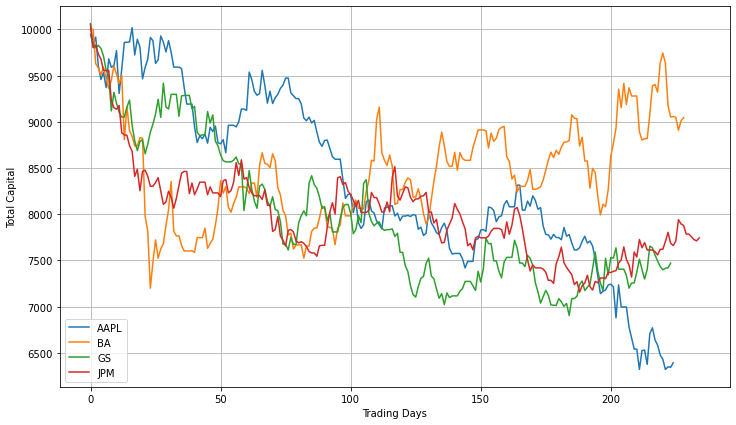

In [69]:
# plot results of trading strategy
fig, ax = plt.subplots(figsize=(12,7))

for i,ticker in enumerate(chosen4.keys()):

    # plot
    ax.plot(ts_results[ticker], label=ticker)
    
ax.grid()
plt.legend()
plt.xlabel('Trading Days')
plt.ylabel('Total Capital')
plt.savefig('../files/experiment_outputs/trading_strategy.png')
plt.show()

In [70]:
# Sharpe Ratio From Scratch
def sharpe_ratio(data, risk_free_rate=0.01):
    # Calculate Average Daily Return
    mean_daily_return = sum(data) / len(data)
    # Calculate Standard Deviation
    s = np.std(data)
    # Calculate Daily Sharpe Ratio
    daily_sharpe_ratio = (mean_daily_return - risk_free_rate) / s
    # Annualize Daily Sharpe Ratio
    sharpe_ratio = 252**(1/2) * daily_sharpe_ratio
    
    return sharpe_ratio

In [71]:
def max_drawdown(data, risk_free_rate=0):
    peak = max(data)
    through = min(data)
    
    mdd = (through-peak)/peak
    return mdd*100

In [72]:
# compute returns and sharpe ratio


metrics = {}

for i, ticker in enumerate(chosen4.keys()):
    metrics[ticker] = {}
    res_df = pd.DataFrame(ts_results[ticker], columns=['Capital'])
    res_df['returns'] = res_df['Capital'].pct_change()
    res_df = res_df.dropna()
    
    # calculate sharpe ratios
    sharpe = sharpe_ratio(res_df['returns'])
    mdd = max_drawdown(res_df['returns'])
    
    # store results 
    metrics[ticker]['sharpe'] = sharpe
    metrics[ticker]['mdd'] = mdd

In [73]:
# print out results

print(pd.DataFrame(metrics).T.to_latex())


\begin{tabular}{lrr}
\toprule
{} &  sharpe &      mdd \\
\midrule
AAPL & -12.080 & -191.080 \\
BA   &  -7.833 & -281.132 \\
GS   & -10.829 & -209.706 \\
JPM  & -13.083 & -176.069 \\
\bottomrule
\end{tabular}



In [ ]:
### EXPERIMENT: RUN TRADING STRATEGY ON ALL OUR STOCKS

# tickers = ['AAPL', 'BA', 'GS', 'JPM']
# gammas = [0.5, 0.9, 0.3, 0.7]

# # store results
# balance_res = {}

# # initiate plot
# fig, ax = plt.subplots(figsize=(12,7))

# for i in range(len(tickers)):

#     # train model
#     model = train_model(tickers[i], chosen4_sent, chosen4_ffc, 0.5)
    
#     # extract and prepare the price data
#     price_df = prep_pricedata(prices_data[i], model, tickers[i], chosen4_ffc, chosen4_sent, gammas[i])
    
#     # run trading strategy, store results
#     total_balance = run_trading_strategy(price_df)
#     balance_res[tickers[i]] = total_balance

#     # plot
#     ax.plot(total_balance, label=tickers[i])
    

# ax.grid()
# plt.legend()
# plt.xlabel('Trading Days')
# plt.ylabel('Total Capital')
# plt.savefig('trading_strategy.png')
# plt.show()

Isolate "dense" window with many sentiment observations